In [1]:
# reload

%load_ext autoreload
%autoreload 2

In [2]:
# import 
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import numpy as np
import sys
import math
#import wandb
from tqdm import tqdm
from functions_dicts_to_parse_data import *
# Increase plot font size from default for all plots instead of setting it in each plot 
plt.rcParams.update({'font.size': 22})

In [3]:
# redirect all print statements to file instead of console

#file_path = 'logs_from_notebook.txt'
#sys.stdout = open(file_path, "w")

In [4]:
#=========================================
# What info / plots do you want displayed
#=========================================
print_logfile_info = True
print_byte_matrix = True
histogram_plots = True
distance_plots = True
timeseries_plots = True; 
# timeseries plots: Which run should I select for timeseries plots 
# (Since it would be too much to plot every UE in every run) 
ts_plot_run_nums = 'run3'; 
# Which UEs (or IMSIs) should we make time series plots for from the ts_plot_run_nums runs 
ts_plot_IMSIs = [1,2,3]
# When using time aggregation to smooth out plots and make 
# them more visually interpretable what window size to use 
time_wind_str = '500ms'
time_wind_val = 500
#===================================
# Data source
#=================================== 
# give the location of the right data source that you want to visualize

# srsPeriodicity40_1msUlSinr is now standard so not adding it in the name 
#data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt_UMi_ISD200m_noShadowing/' 
#data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt_UMaPropagationModel_ISD200m_noShadowing/'
#data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt_RangePropagationLossModel300m_ISD200m_noShadowing/'
#data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt_RangePropagationLossModel300m_ISD200m_noShadowing_ueTxPower30/' 

# Notes: Even when I say that it is RMa or RangePropagationLossModel it is going through the UMi if conditions so as to use UMi distances etc. 
# so that we only change the propagation model. 
# The steps here are all best case with one thing added on top. It is not incremental addition 
# - shadowing with versus without
# - easy peasy prop model versus UMi 
# - 23 dB versus 30 dB Tx power of UE (23 is the max allowed by standard for UE and 30 is the Tx power od BS,
# so i am trying to see I set UE tx power to same as BS will UL become as good as the downllink )    
        
# These should be the best case scenario where we have a low loss propagation model with no shadowing and the max BS to UE distance is low 
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_RangePropagationLossModel300m_ISD200m_noShadowing_ueTxPower30/'
# To check how much worse it gets when we reduce the Tx power of UE to max allowed level of 23dB
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_RangePropagationLossModel300m_ISD200m_noShadowing_ueTxPower23/'
# To check what happens when we switch up the model to UMi which has more path loss
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_noShadowing_ueTxPower23/'
# To check what happens when we introduce shadowing
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23/'
# Made the A3 handover more conservative to see of the large number of handovers in the fast UEs wil reduce 
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_conservativeA3HO/'
#Made the A2A4 handover more conservative to see of the large number of handovers in the fast UEs wil reduce 
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_conservativeA2A4HO/'
# made it extremely conservative becaude the other one has no effect 
#data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_extremelyConservativeA2A4HO/'
# to see if 130 to 120 degree beamwifth reduces intereference 
data_dir = '../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/'
# To check what happens when we increase inter site distance to what it was in the script - 500 m 
#data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt_RangePropagationLossModel300m_noShadowing_ueTxPower30/'

print('Raw data folder: \n'+data_dir+'\n')


plot_dir = './plots/'+data_dir.split('/')[-2]+'/'
print('Plots saved in folder: \n'+plot_dir+'\n')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

info_file = open(data_dir+'run1/simulation_info.txt')
for i in range(95):
    print(info_file.readline())
    
# This is a subset of log files that we would like to parse and plot at the moment depending on what is in the data 
#files = ['delay_trace.txt', 'mobility_trace.txt']
files = ran_files+['rtt_trace.txt', 'delay_trace.txt', 
         'handover_trace.txt', 'mobility_trace.txt']
         #'ulThroughput_trace.txt']         
         #'vrBurst_trace.txt', 'vrFragment_trace.txt',
         #'dashClient_trace.txt', 'mpegPlayer_trace.txt', # video streaming
         #'httpServerDelay_trace.txt', 'httpClientDelay_trace.txt', 'httpClientRtt_trace.txt']

# Specify here topology details from the dataset we are using 
# This can be infered from the files, but this is easier 
total_num_cells=3
total_num_ues=3
num_runs = 10
sim_time = 200 # seconds
sim_start_time = pd.to_datetime(0, unit='s', origin='unix')
sim_end_time = pd.to_datetime(sim_time, unit='s', origin='unix')

dict_gnb_pos = pd.read_csv(data_dir+'run1/gnb_locations.txt', sep=',').set_index('cellId').to_dict('index')
dict_gnb_pos[0] = {'gnbpos_x': np.nan, 'gnbpos_y': np.nan, 'gnbpos_z': np.nan}

Raw data folder: 
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/

Plots saved in folder: 
./plots/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/

Waf: Entering directory `/home/ubuntu/mobile-network-datasets-ns3/ns-3-dev/build'



Scenario Topology Parameters:           

                                        

Macro layer BS positions:               Regular hexaonal lay down

Macro layer num of rings:               0

Macro layer num of BSs:                 0

Micro layer BS antenna pattern:         Cosine 130 degrees

Micro layer of BSs:                     Disabled

Num of UEs:                             0

Number of UEs per BS (per sector):      1

Antenna down tilt angle:                0 deg

3GPP Scenario:                          UMi

  (ISD: 0.5 km, BS height: 10 m, UE height: 1.5 m, UE-BS min dist: 10 m)

                                        

Radio Parameters:                       

                                        

Radi

In [5]:
# initilize wandb for experiment tracking
config_dict = {'dataset': data_dir.split('/')[-2], 'window size': time_wind_str, 'log files processed': files,
              'simulation time': sim_time, 'num of cells': total_num_cells, 'num of UEs':total_num_ues,
              'num of runs':num_runs, 'run used for timeseriess plots': ts_plot_run_nums, 
               'IMSIs used for timeseries plots':ts_plot_IMSIs}
#wandb.init(project="mobile-radio-dataset", entity="network-intelligence", config=config_dict)
print(config_dict)

{'dataset': 'lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam', 'window size': '500ms', 'log files processed': ['DlTxPhyStats.txt', 'UlRxPhyStats.txt', 'UlSinrStats.txt', 'UlPdcpStats.txt', 'DlRsrpSinrStats.txt', 'UlRlcStats.txt', 'UlMacStats.txt', 'UlTxPhyStats.txt', 'DlPdcpStats.txt', 'DlRlcStats.txt', 'DlRxPhyStats.txt', 'DlMacStats.txt', 'rtt_trace.txt', 'delay_trace.txt', 'handover_trace.txt', 'mobility_trace.txt'], 'simulation time': 200, 'num of cells': 3, 'num of UEs': 3, 'num of runs': 10, 'run used for timeseriess plots': 'run3', 'IMSIs used for timeseries plots': [1, 2, 3]}


  0%|                                                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run3
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run3/DlTxPhyStats.txt
time to read file:  0.010702848434448242
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.523 ,  200.879 )
log runtime: 200.356  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run3/UlRxPhyStats.txt
time to read file:  0.00904703140258789
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.52 ,  200.818 )
log runtime: 200.298  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run3/UlSinrStats.txt
time to read file:  0.006684064865112305
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.281 ,  201.044 )
log runtime: 200.763  seconds
------------

 10%|███████████████████████▊                                                                                                                                                                                                                      | 1/10 [00:01<00:17,  1.97s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[53 53 17 17]
 [47 47 17 17]
 [53  0 17 17]
 [38  0 17 17]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run6
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run6/DlTxPhyStats.txt
time to read file:  0.0054416656494140625
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.506 ,  200.612 )
log runtime: 200.106  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run6/UlRxPhyStats.txt
time to read file:  0.009598016738891602
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.568 ,  200.811 )
log runtime: 200.243  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_12

 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 2/10 [00:03<00:14,  1.82s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[51 51 16 16]
 [40 40 16 17]
 [51  0 16 16]
 [34  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run8
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run8/DlTxPhyStats.txt
time to read file:  0.0054743289947509766
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.526 ,  200.824 )
log runtime: 200.298  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run8/UlRxPhyStats.txt
time to read file:  0.008951663970947266
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.572 ,  200.761 )
log runtime: 200.189  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_12

 30%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 3/10 [00:05<00:12,  1.81s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[51 51 16 16]
 [41 41 16 17]
 [51  0 16 16]
 [36  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run5
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run5/DlTxPhyStats.txt
time to read file:  0.005591154098510742
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.512 ,  200.883 )
log runtime: 200.371  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run5/UlRxPhyStats.txt
time to read file:  0.006773948669433594
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.513 ,  200.813 )
log runtime: 200.29999999999998  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTx

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 4/10 [00:07<00:10,  1.77s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[52 52 16 16]
 [46 46 16 17]
 [52  0 16 16]
 [39  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run7
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run7/DlTxPhyStats.txt
time to read file:  0.0055429935455322266
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.598 ,  200.554 )
log runtime: 199.956  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run7/UlRxPhyStats.txt
time to read file:  0.008191347122192383
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.528 ,  200.835 )
log runtime: 200.30700000000002  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueT

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 5/10 [00:08<00:08,  1.74s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[53 53 17 17]
 [46 46 17 17]
 [53  0 17 17]
 [46  0 17 17]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run10
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run10/DlTxPhyStats.txt
time to read file:  0.006376028060913086
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.579 ,  200.834 )
log runtime: 200.255  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run10/UlRxPhyStats.txt
time to read file:  0.010703802108764648
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.576 ,  200.898 )
log runtime: 200.322  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 6/10 [00:10<00:07,  1.79s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[52 52 17 17]
 [42 42 16 17]
 [52  0 17 17]
 [42  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9/DlTxPhyStats.txt
time to read file:  0.006684064865112305
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.584 ,  200.828 )
log runtime: 200.244  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9/UlRxPhyStats.txt
time to read file:  0.00797891616821289
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.645 ,  200.825 )
log runtime: 200.17999999999998  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxP

/tmp/ipykernel_161714/2382547330.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_delay, axs_delay = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)


--------------------------------------------
UlPdcpStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9/UlPdcpStats.txt
time to read file:  0.005950450897216797
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.5 ,  200.75 )
log runtime: 200.25  seconds
--------------------------------------------
DlRsrpSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9/DlRsrpSinrStats.txt
time to read file:  0.007944822311401367
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.239214 ,  201.016 )
log runtime: 200.776786  seconds
--------------------------------------------
UlRlcStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run9/UlRlcStats.txt
time to read file:  0.004708528518676758
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.5 ,  200.75 )
log runtime: 200.25  seconds
--------------------------------------------
UlMacStats.txt
../../data_volume/lte_3macro_3

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 7/10 [00:12<00:05,  1.79s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[51 51 16 16]
 [43 43 16 17]
 [51  0 16 16]
 [43  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run1
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run1/DlTxPhyStats.txt
time to read file:  0.006038665771484375
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.627 ,  200.785 )
log runtime: 200.158  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run1/UlRxPhyStats.txt
time to read file:  0.010278463363647461
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.665 ,  200.797 )
log runtime: 200.132  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8/10 [00:14<00:03,  1.83s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[51 51 16 16]
 [33 33 16 17]
 [51  0 16 16]
 [32  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run4
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run4/DlTxPhyStats.txt
time to read file:  0.005956888198852539
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.696 ,  200.91 )
log runtime: 200.214  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run4/UlRxPhyStats.txt
time to read file:  0.009018898010253906
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.606 ,  200.918 )
log runtime: 200.312  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120B

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 9/10 [00:16<00:01,  1.79s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[52 52 16 16]
 [41 41 16 17]
 [52  0 16 16]
 [41  0 16 16]]
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run2
--------------------------------------------
DlTxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run2/DlTxPhyStats.txt
time to read file:  0.006512641906738281
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.513 ,  200.61 )
log runtime: 200.097  seconds
--------------------------------------------
UlRxPhyStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120Beam/run2/UlRxPhyStats.txt
time to read file:  0.007354021072387695
ueIds: min: 1 max: 3 count: 3
log time (start, end): ( 0.633 ,  200.806 )
log runtime: 200.173  seconds
--------------------------------------------
UlSinrStats.txt
../../data_volume/lte_3macro_3Ue_delay_rtt_UMi_ISD200m_ueTxPower23_120B

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[52 52 17 17]
 [44 44 17 17]
 [52  0 17 17]
 [44  0 17 16]]


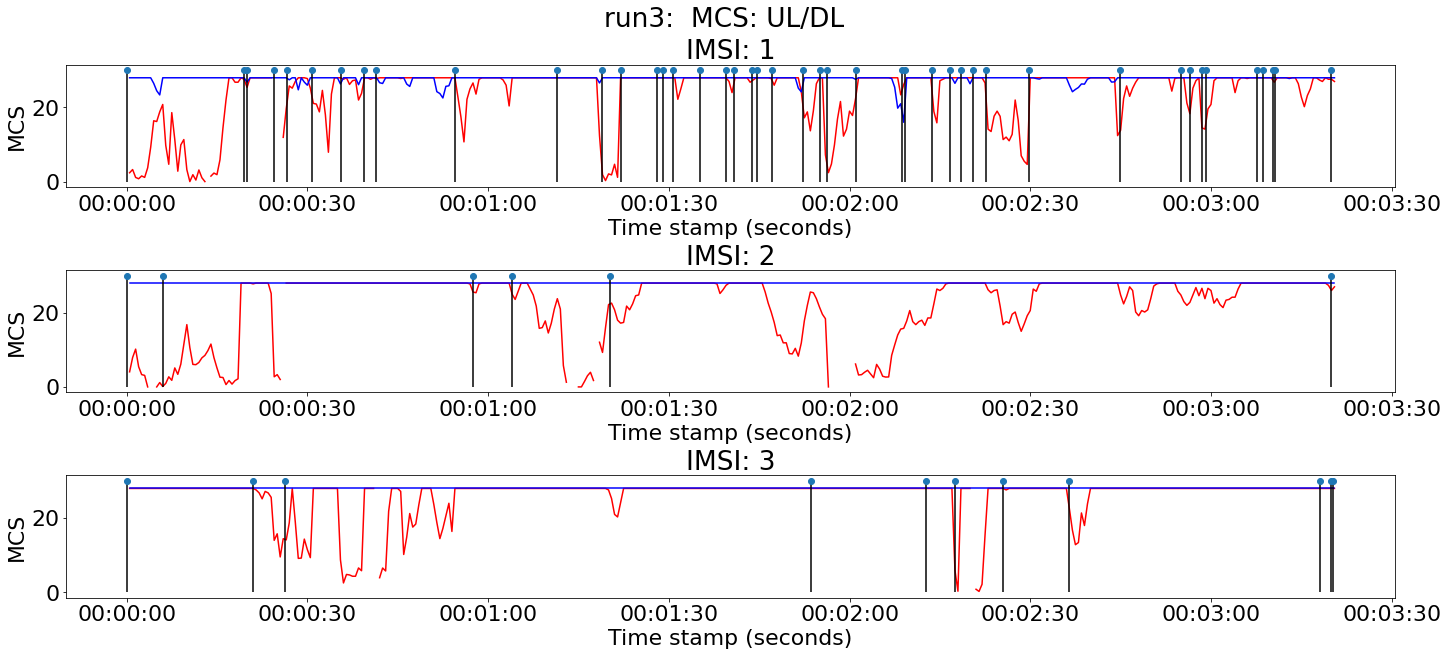

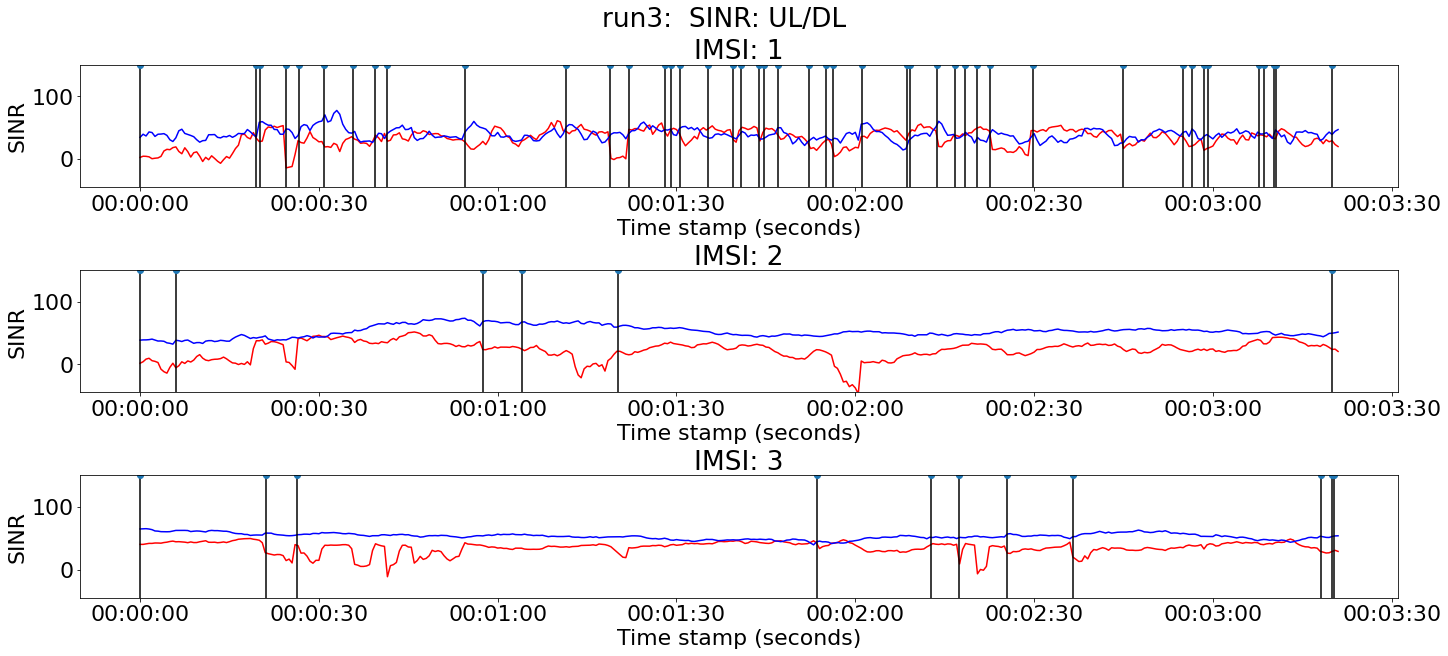

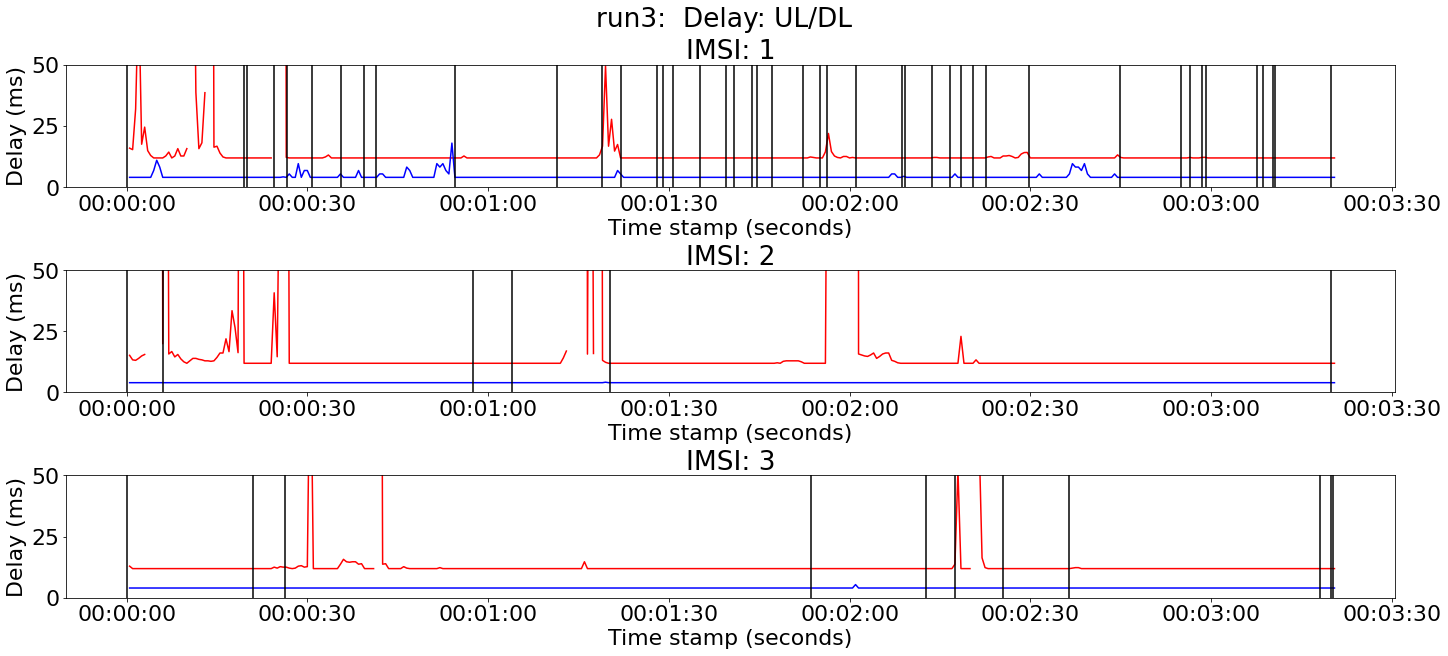

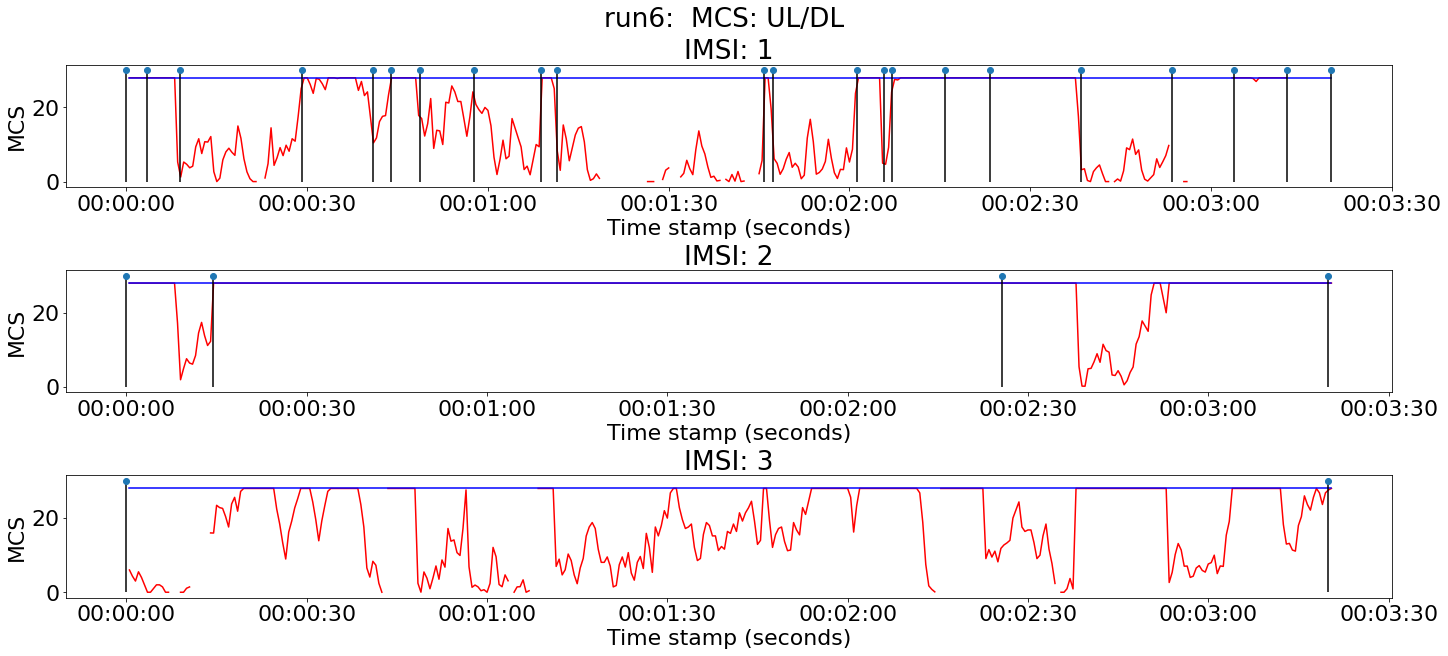

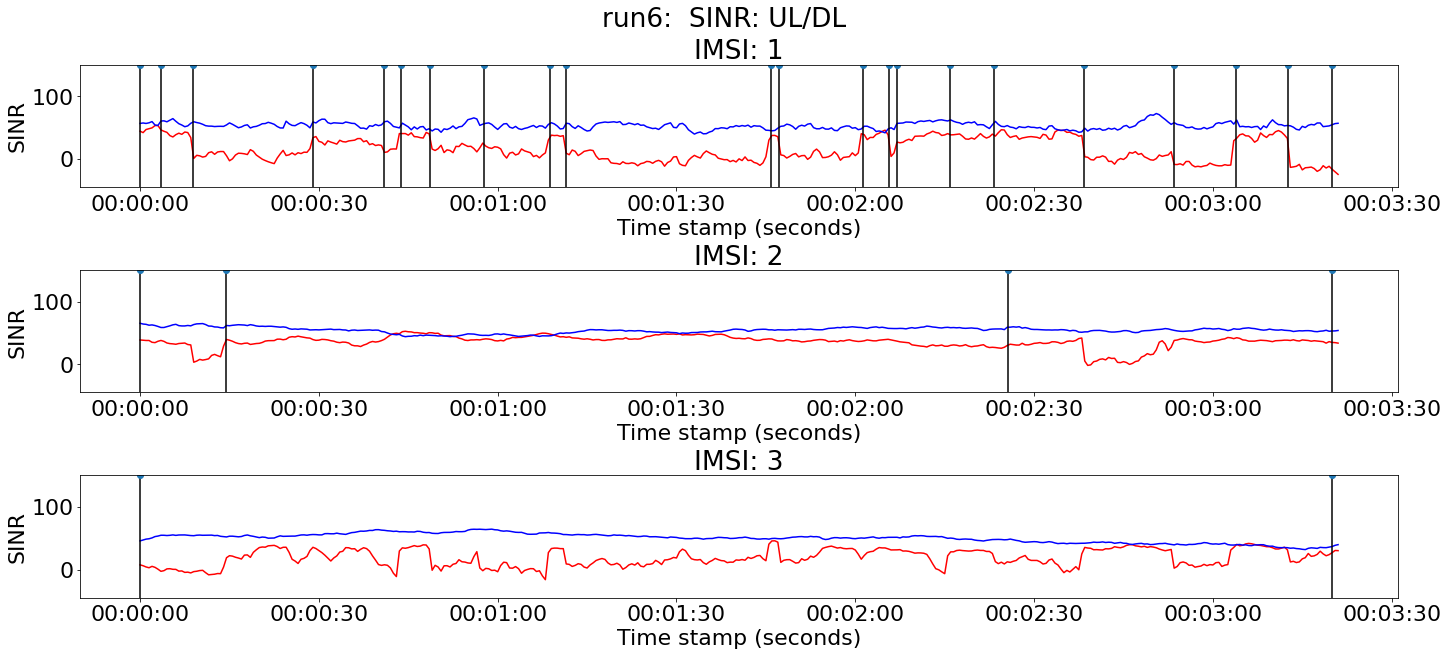

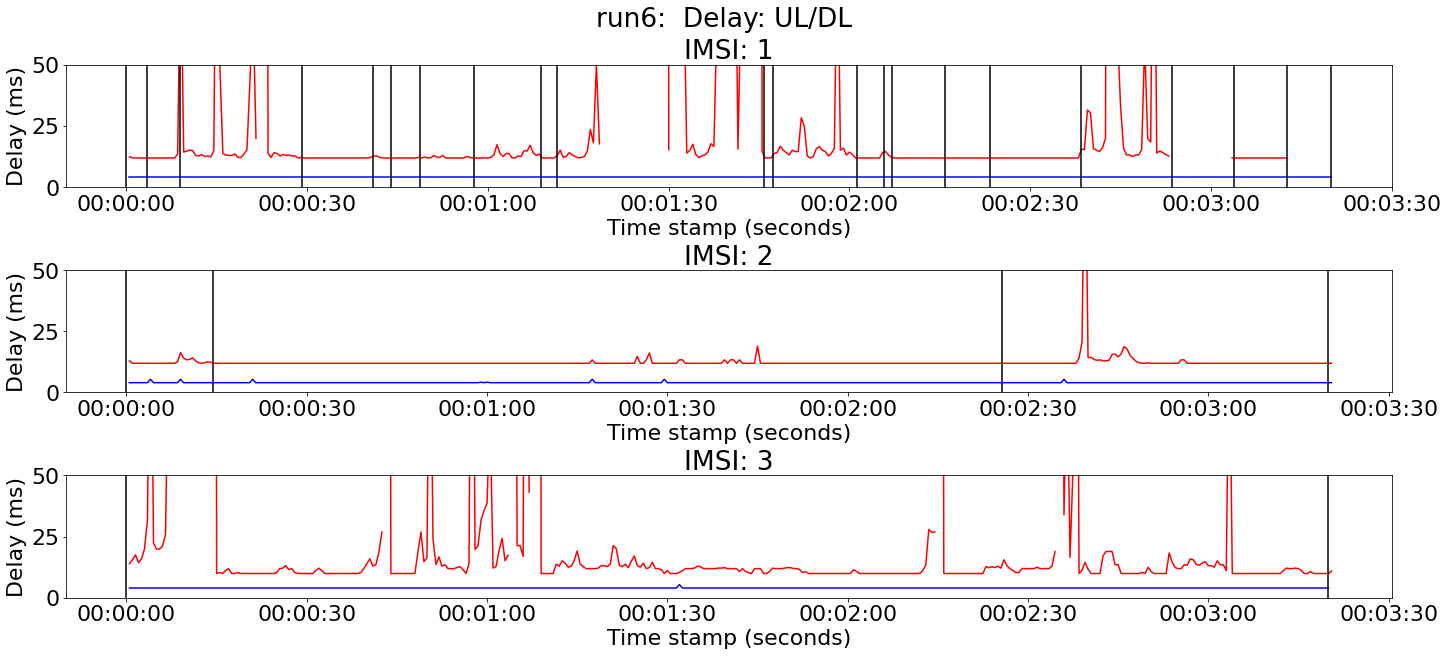

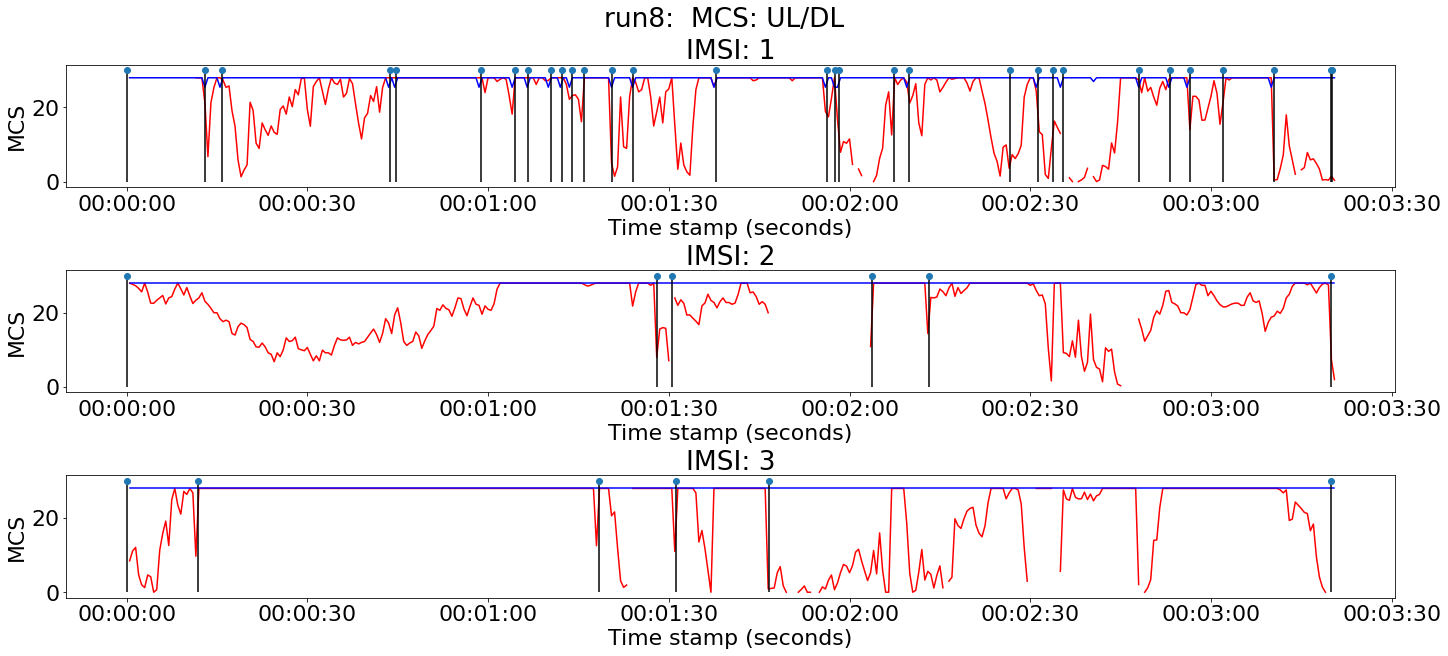

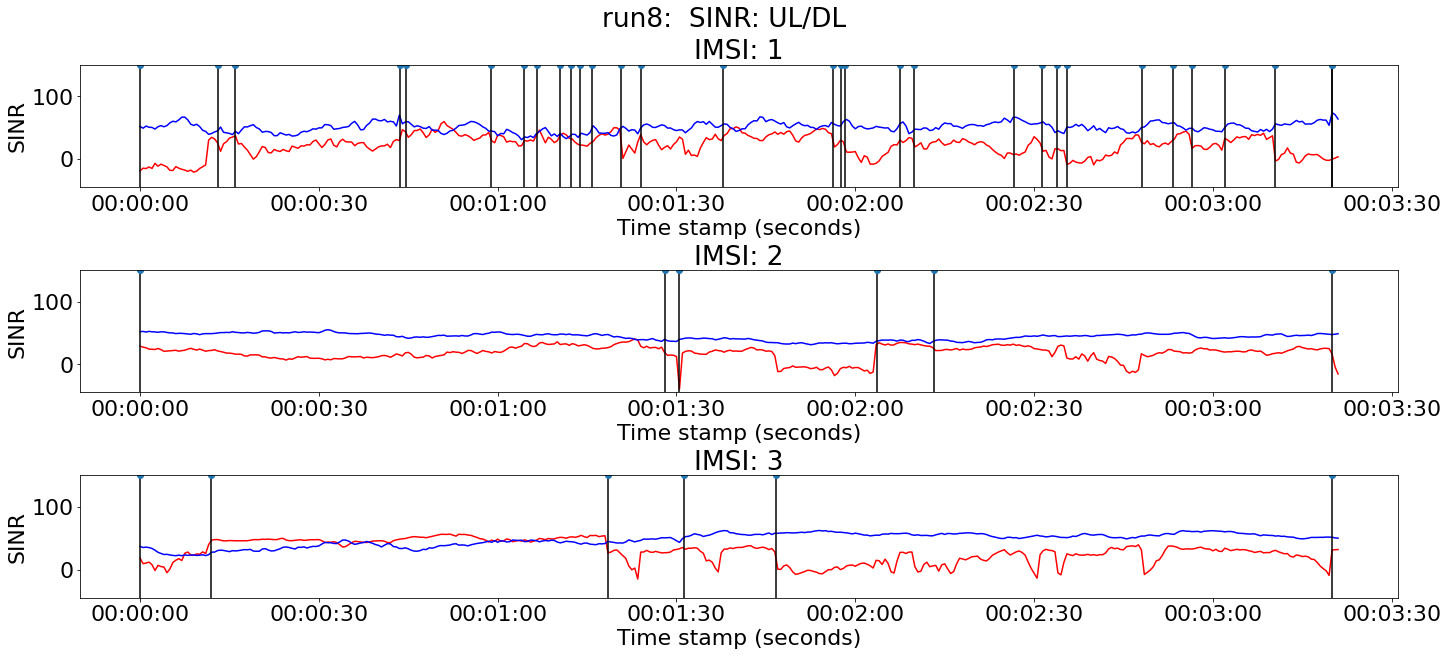

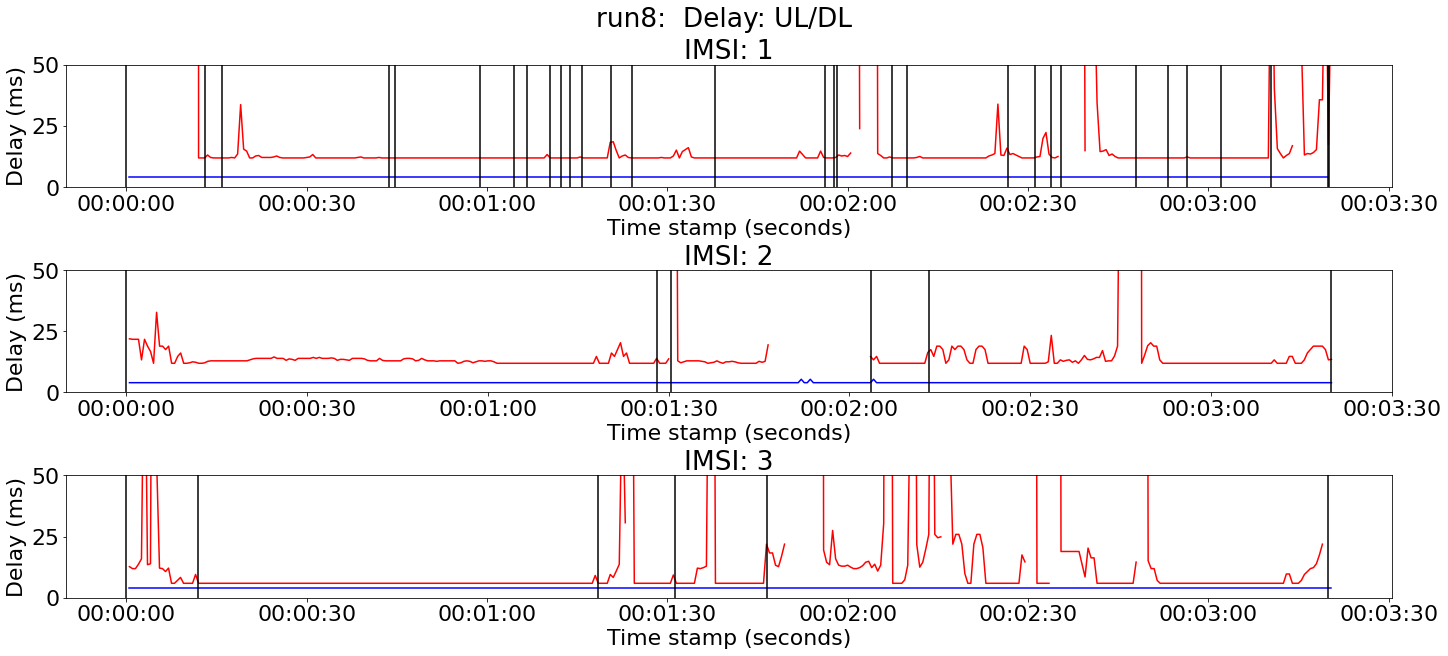

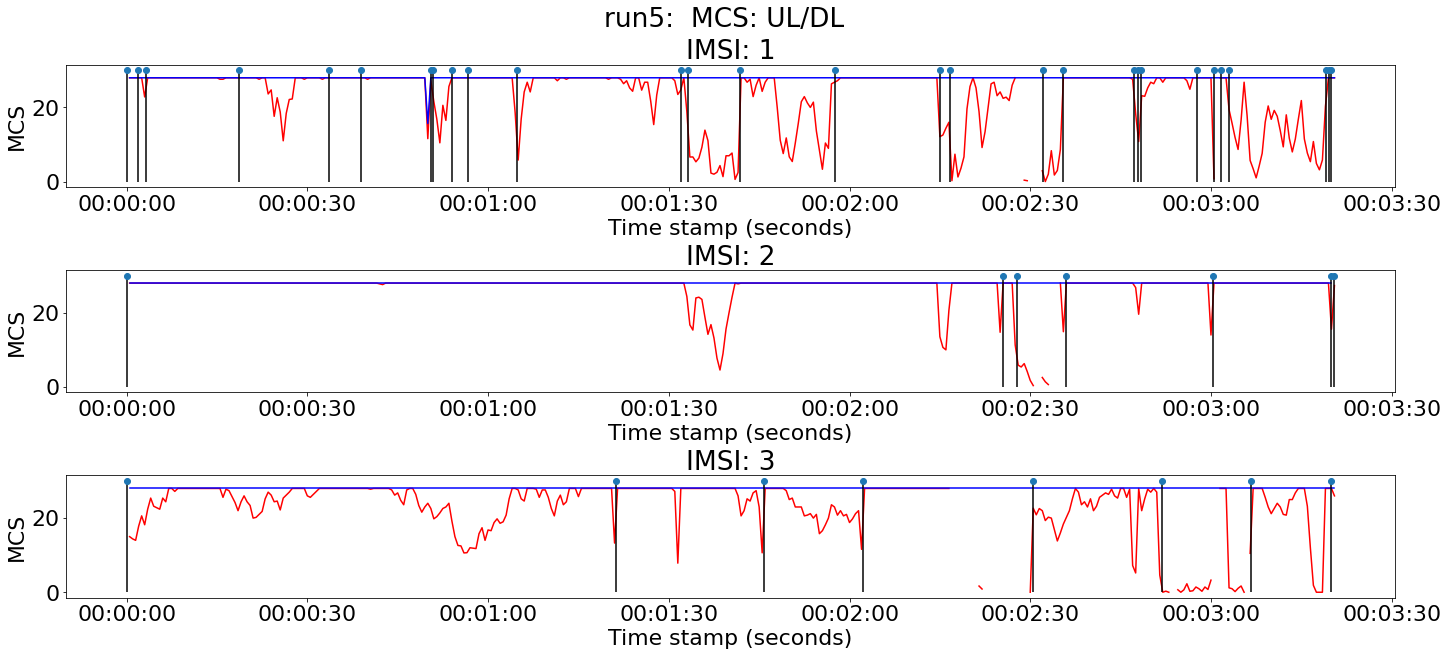

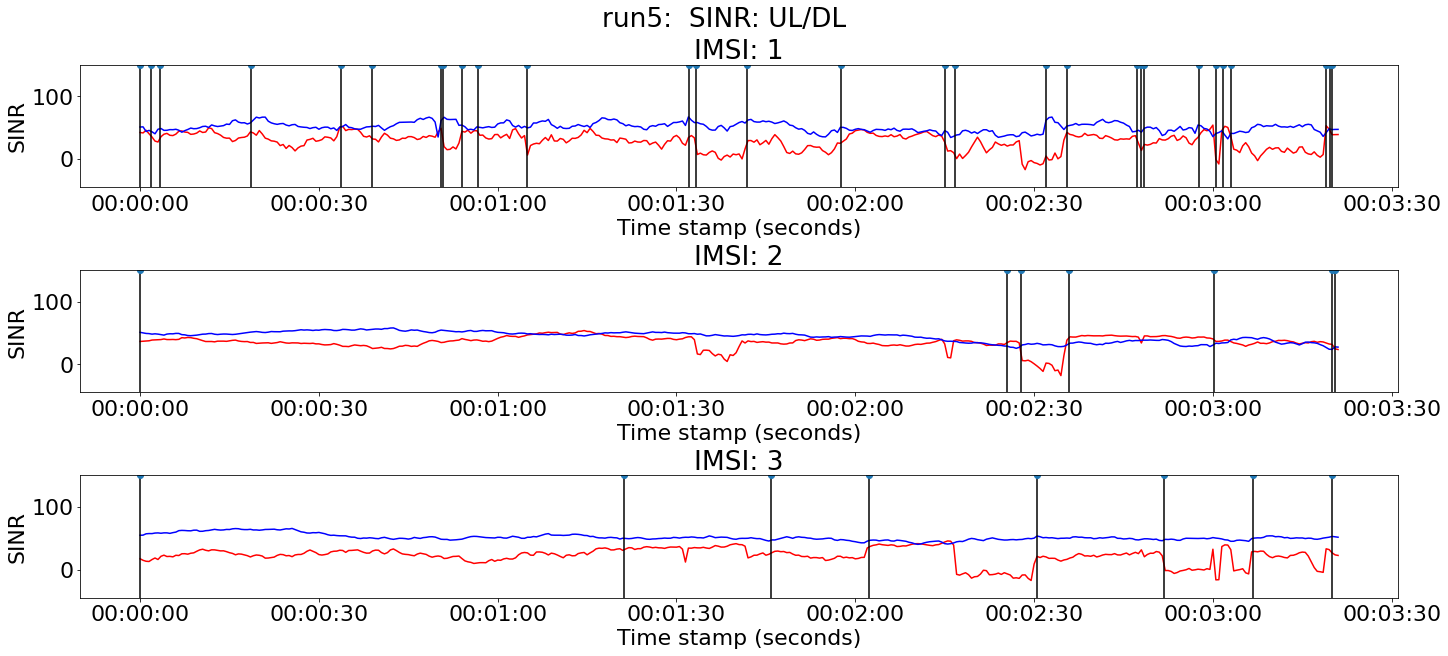

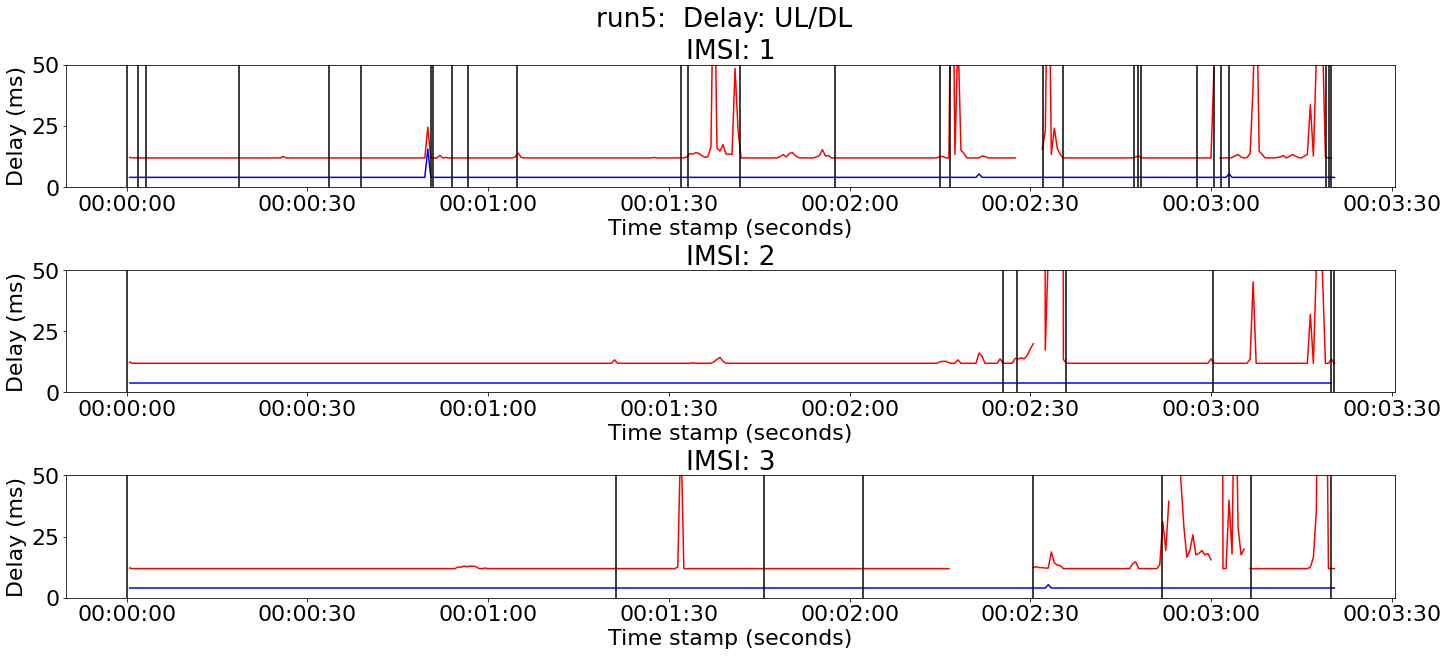

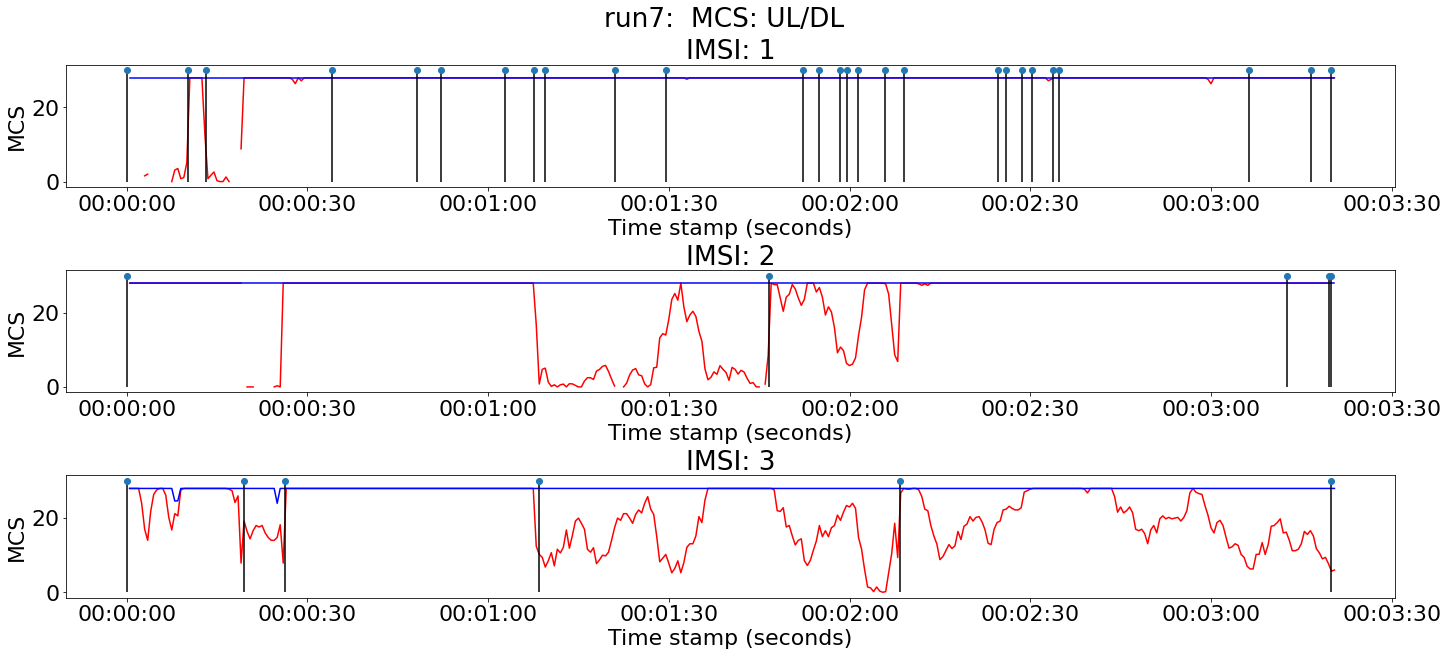

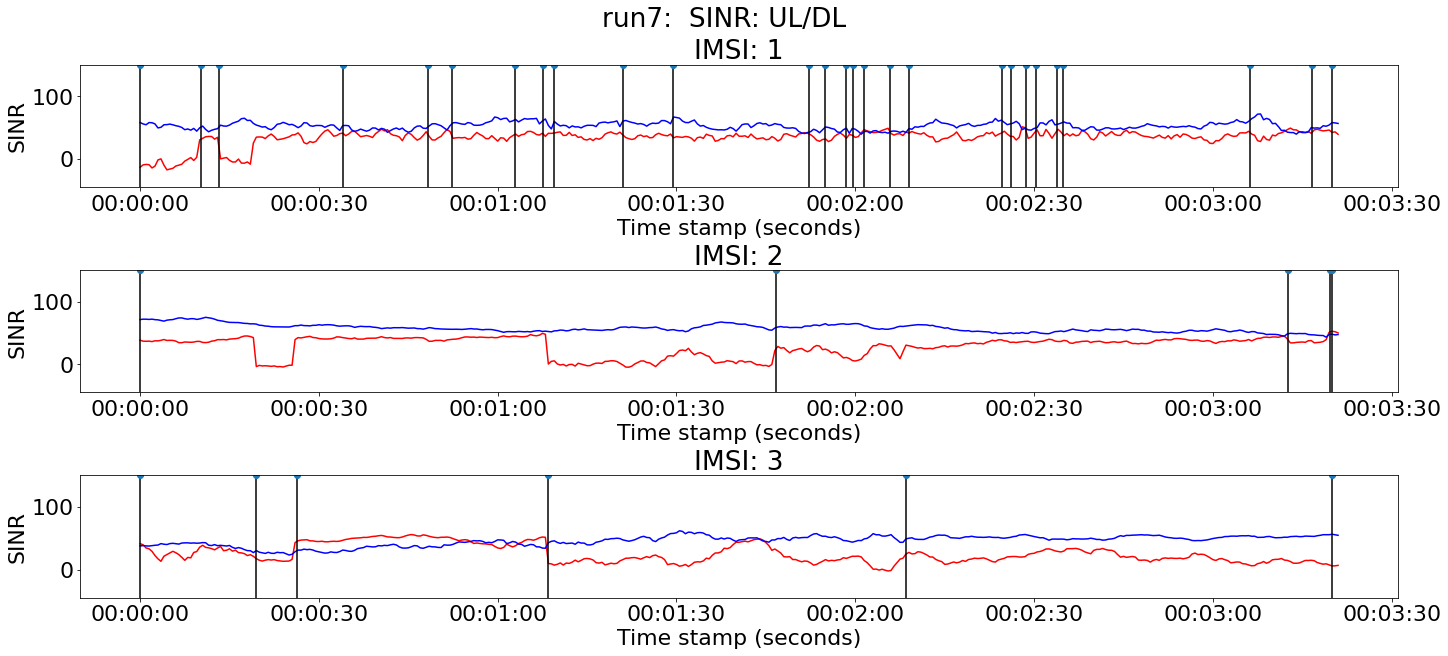

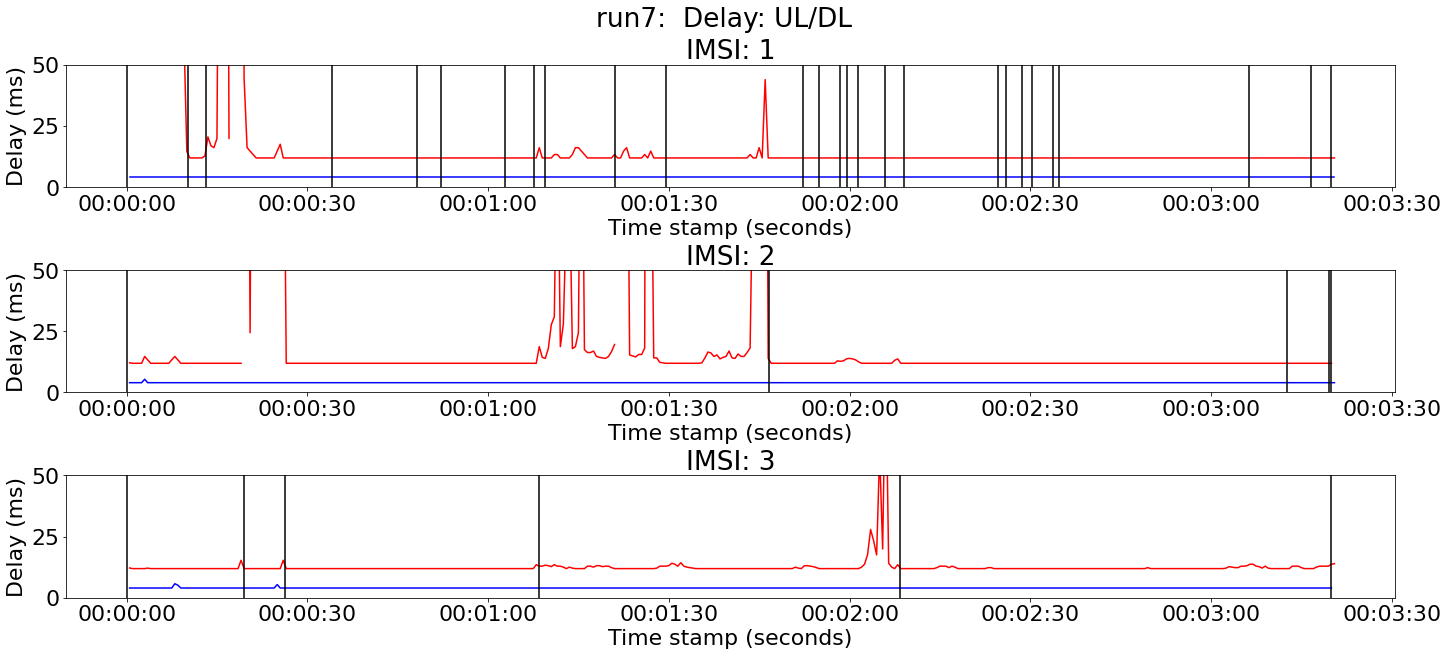

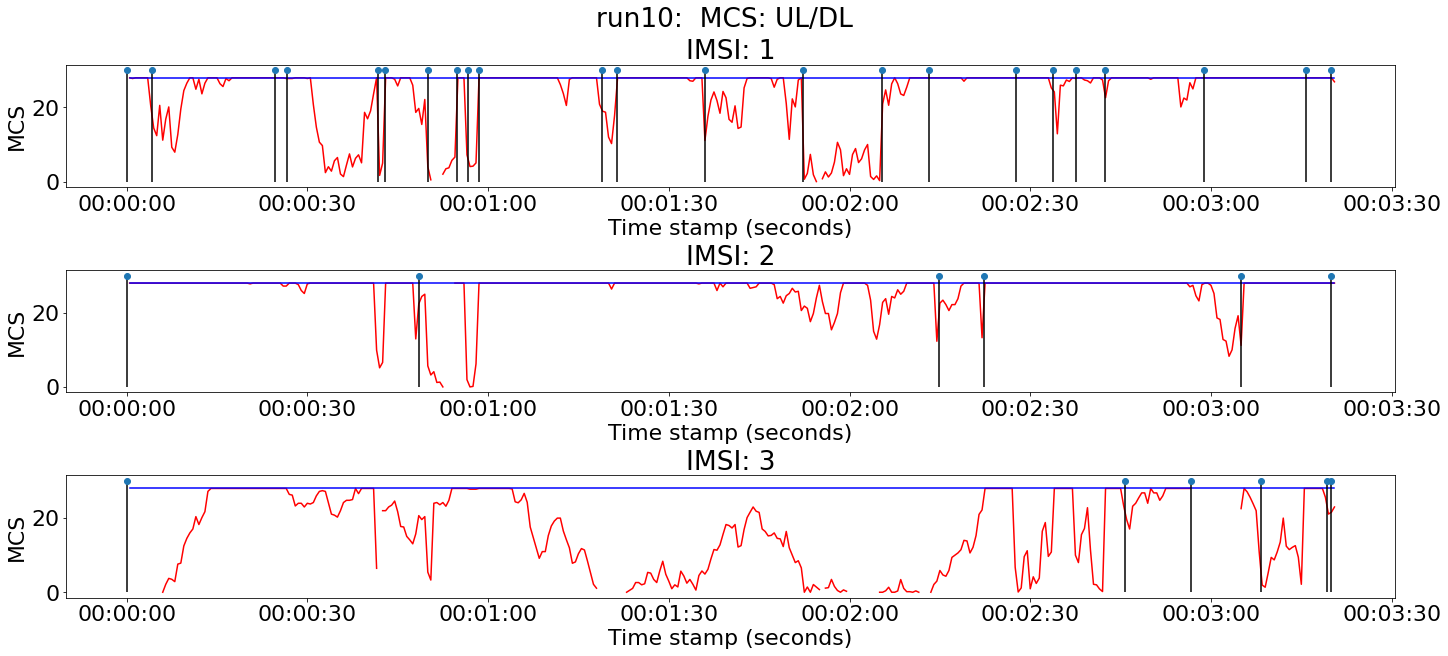

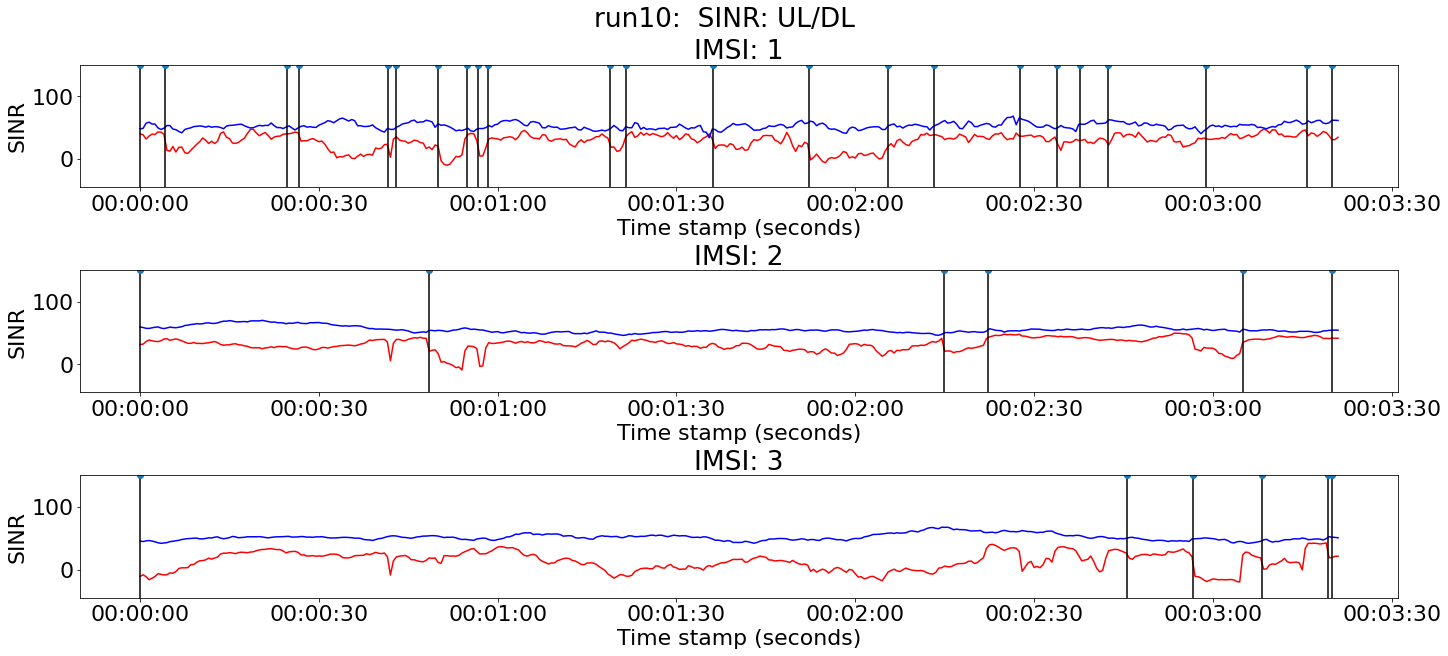

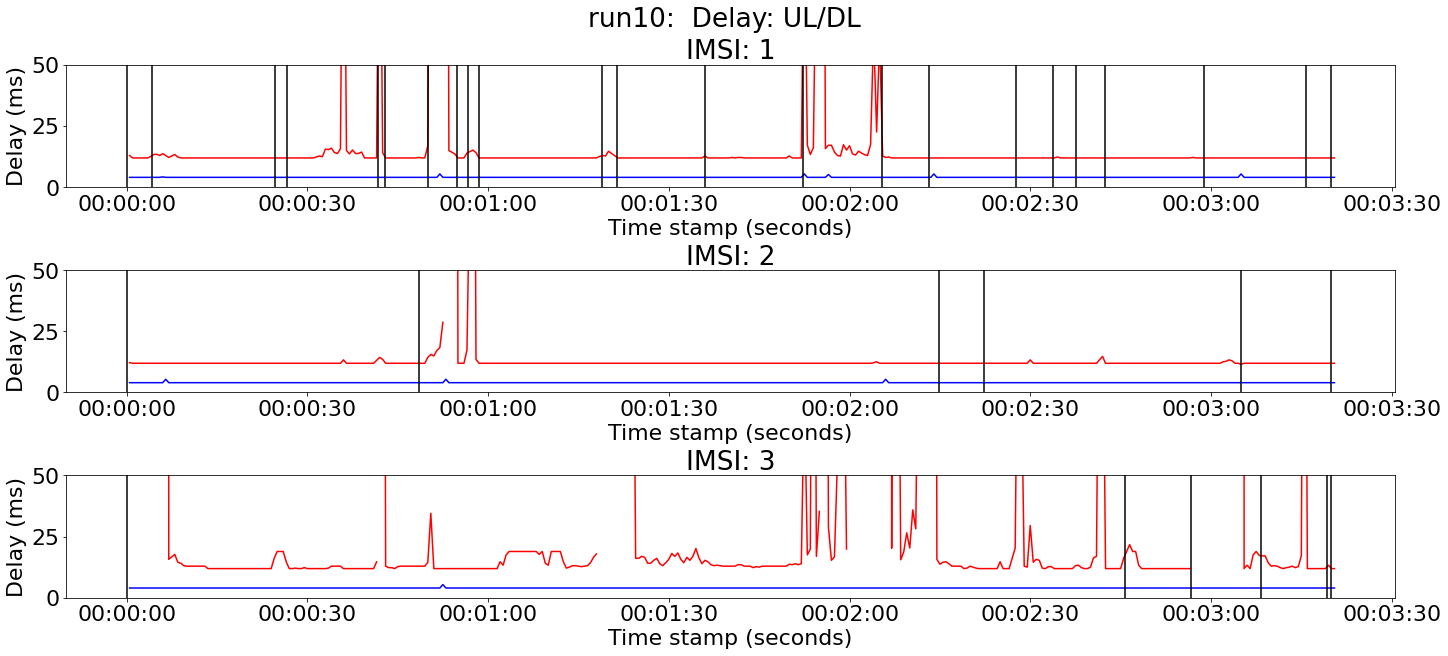

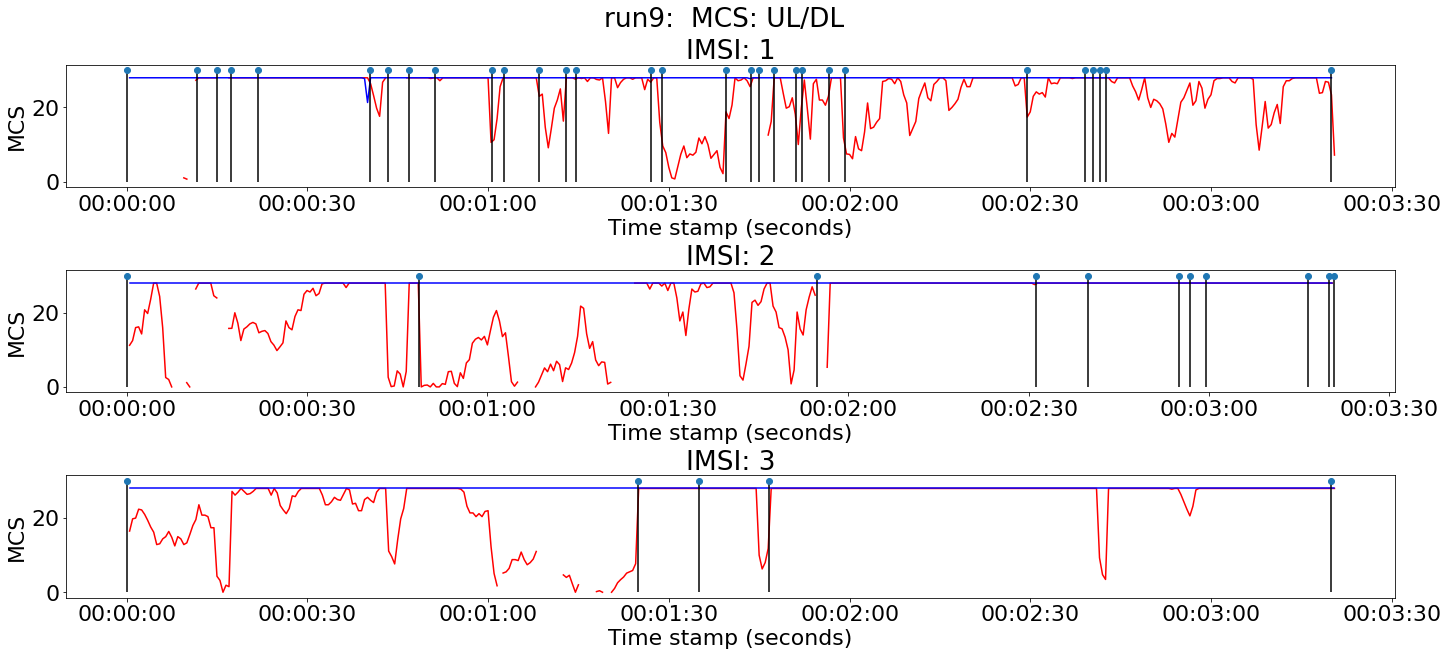

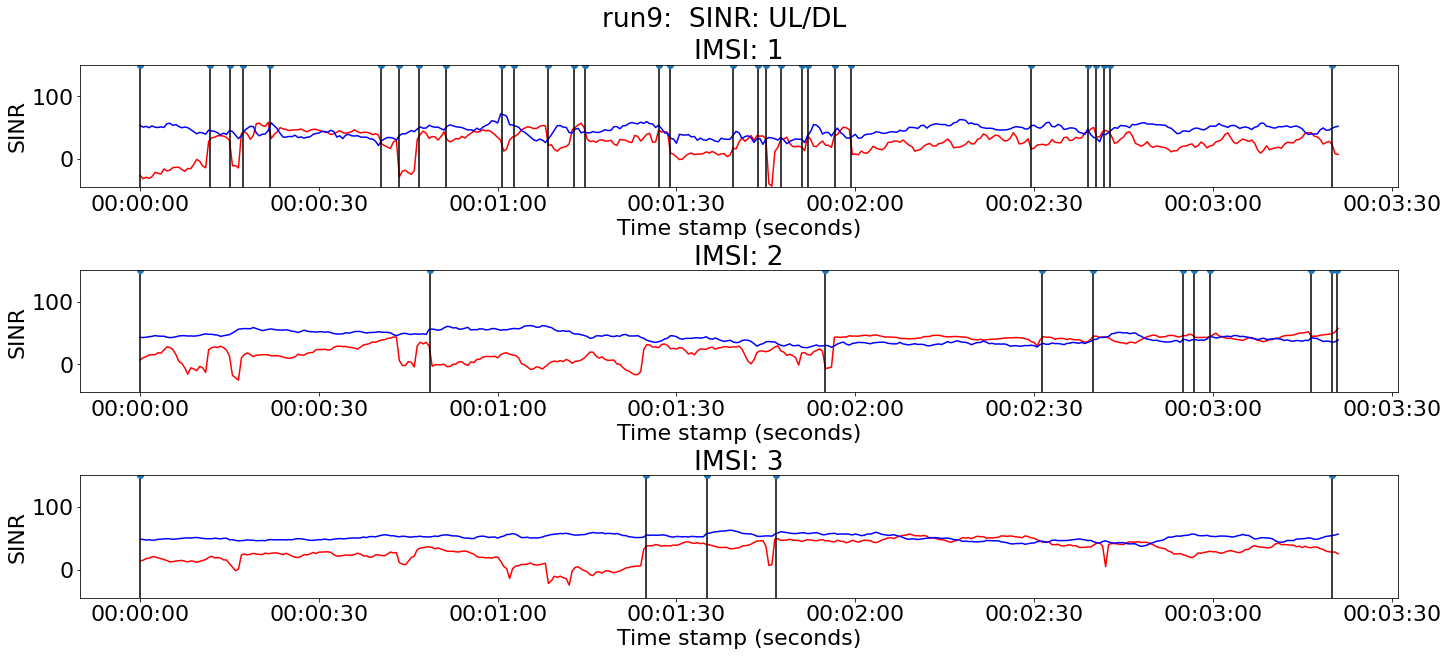

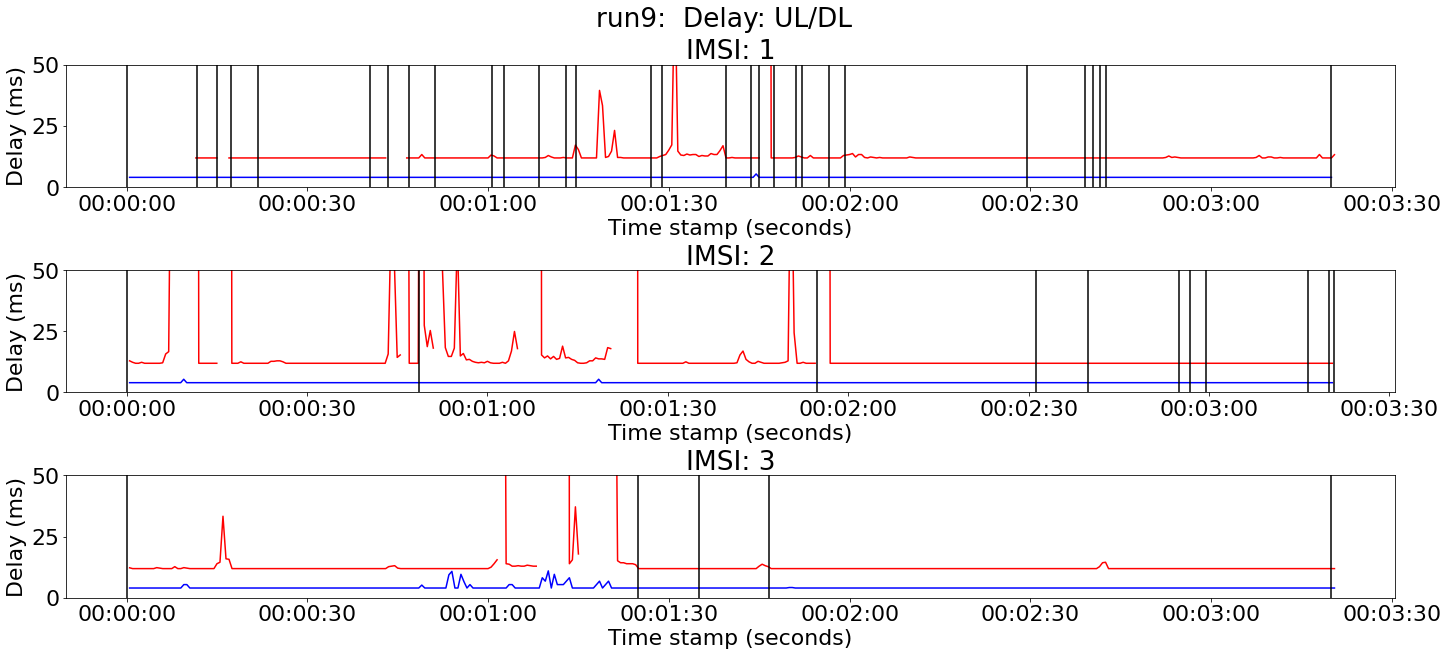

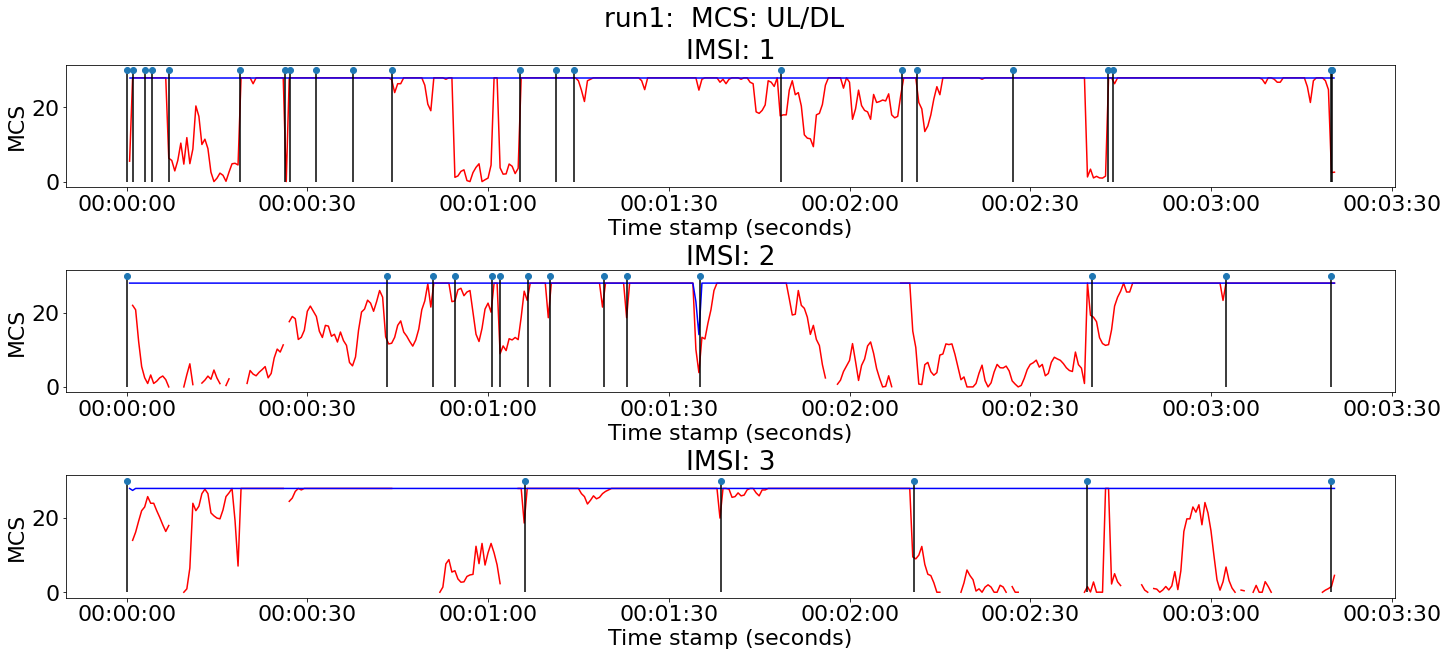

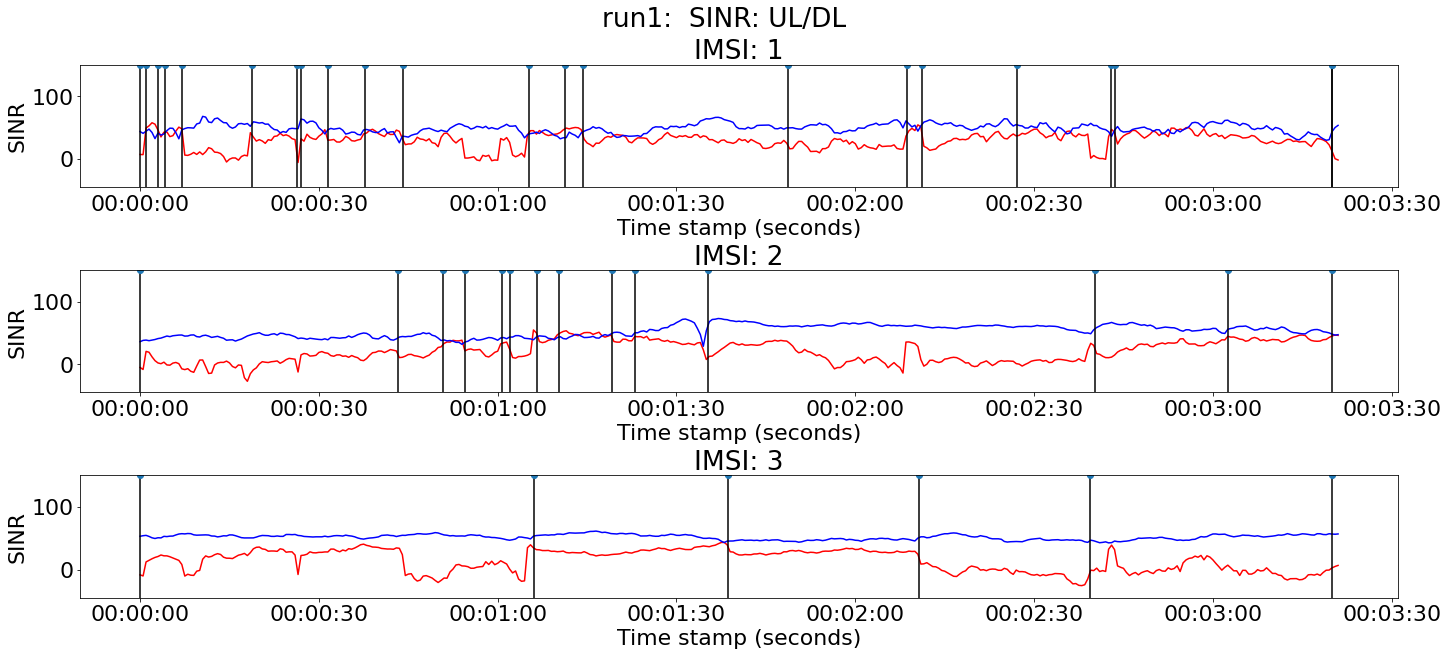

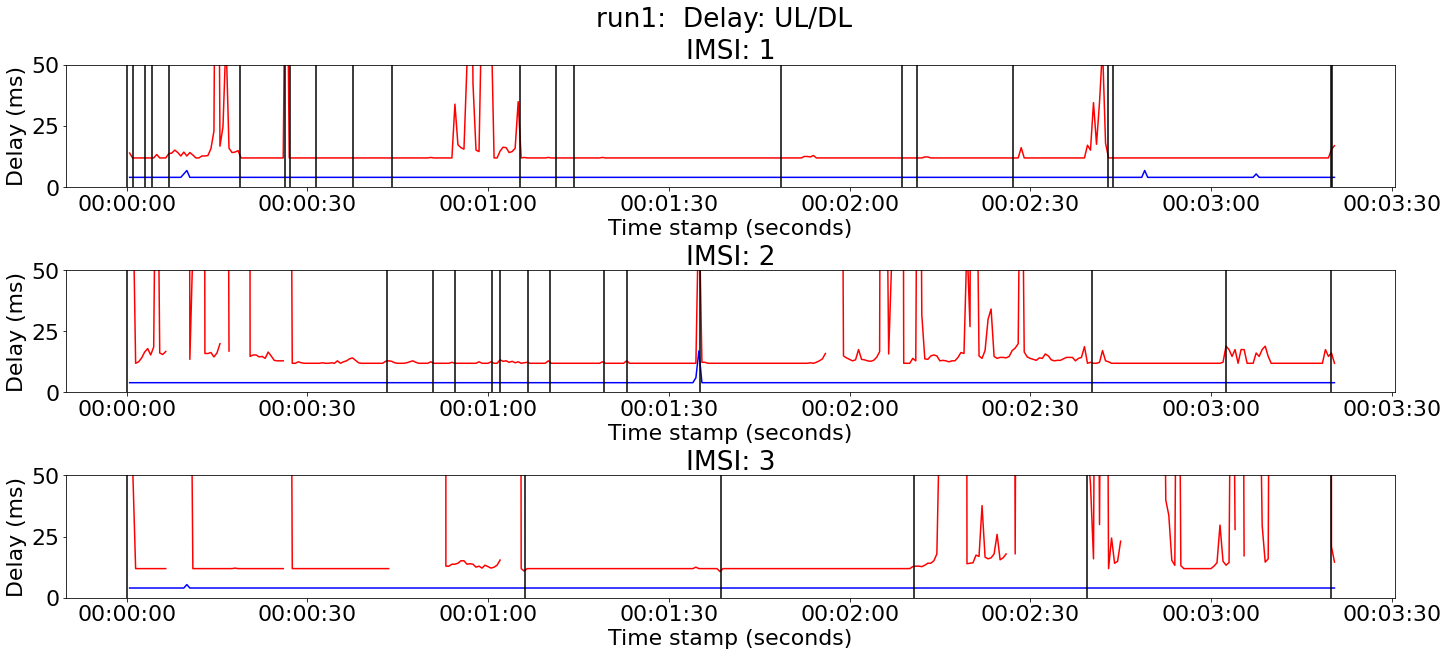

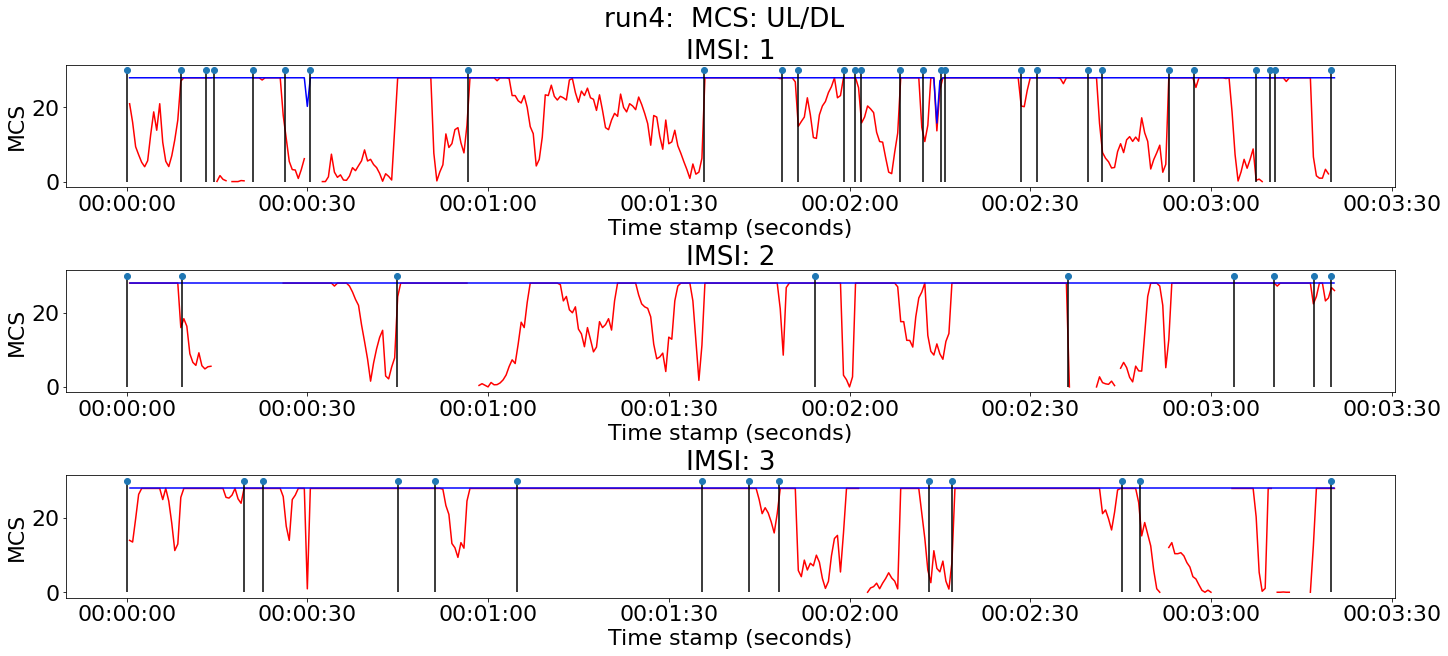

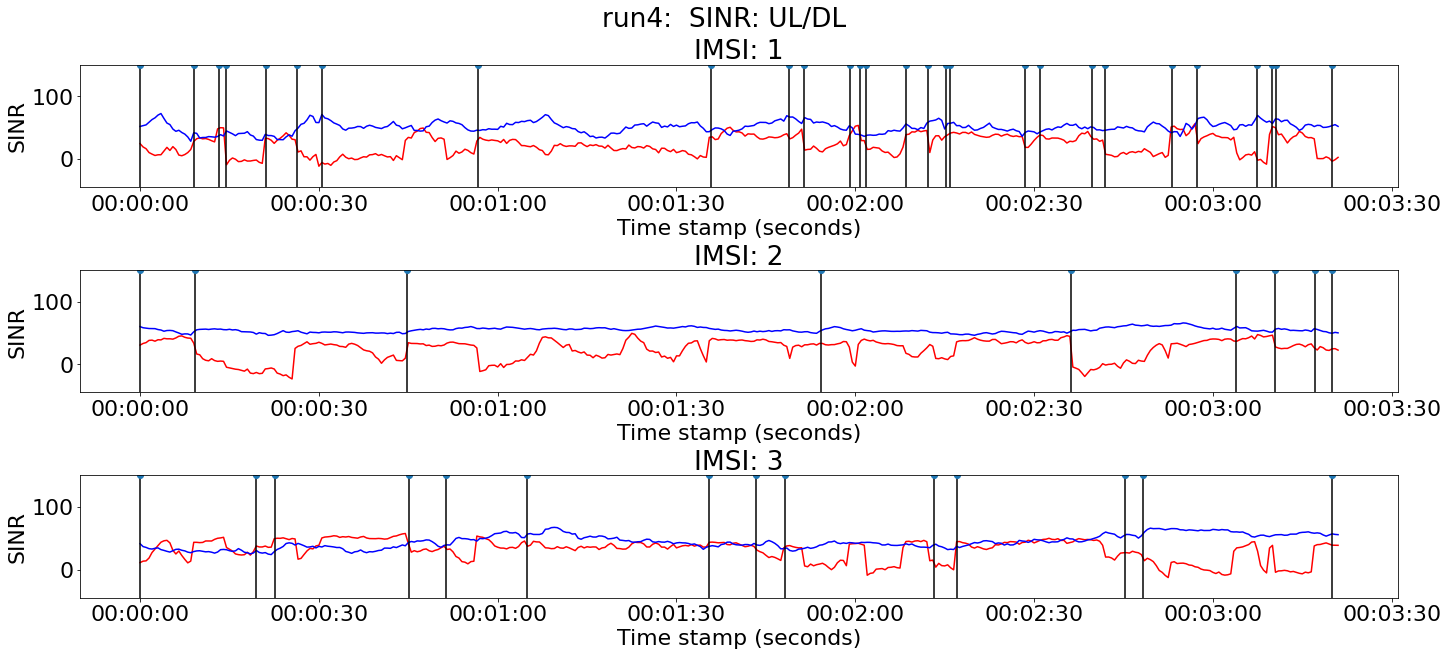

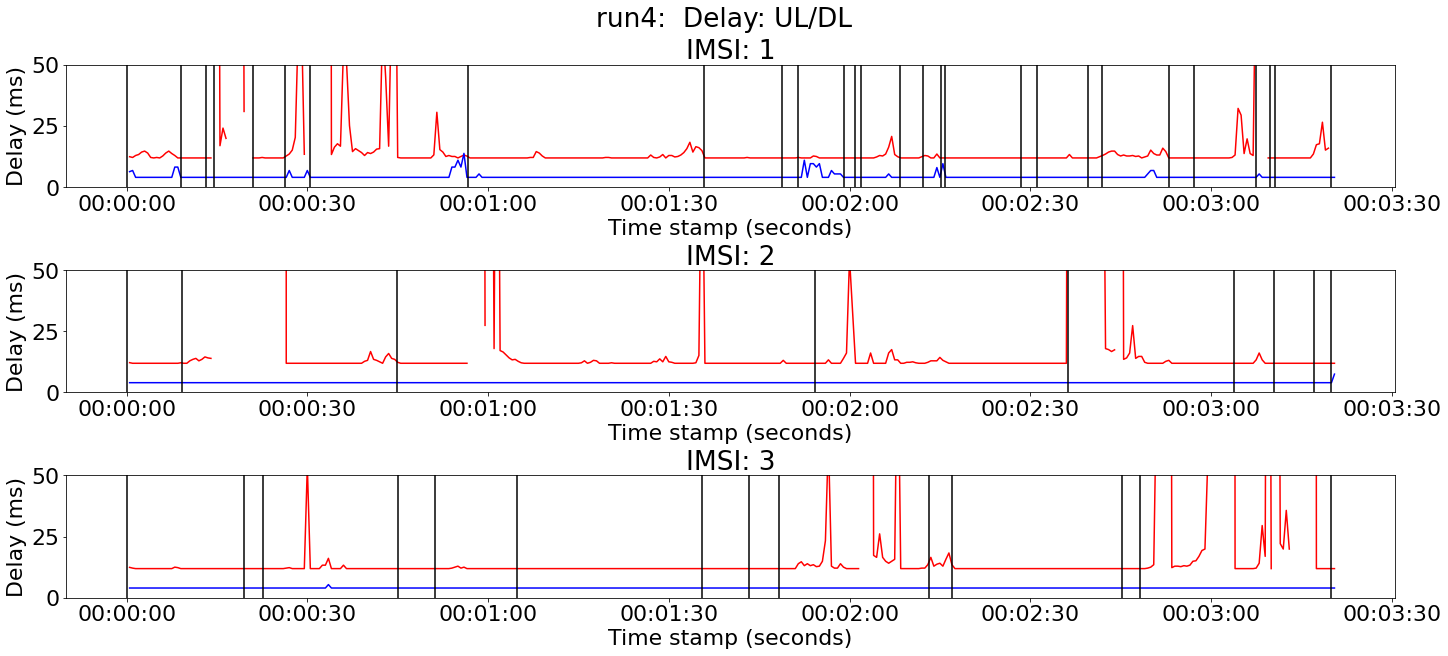

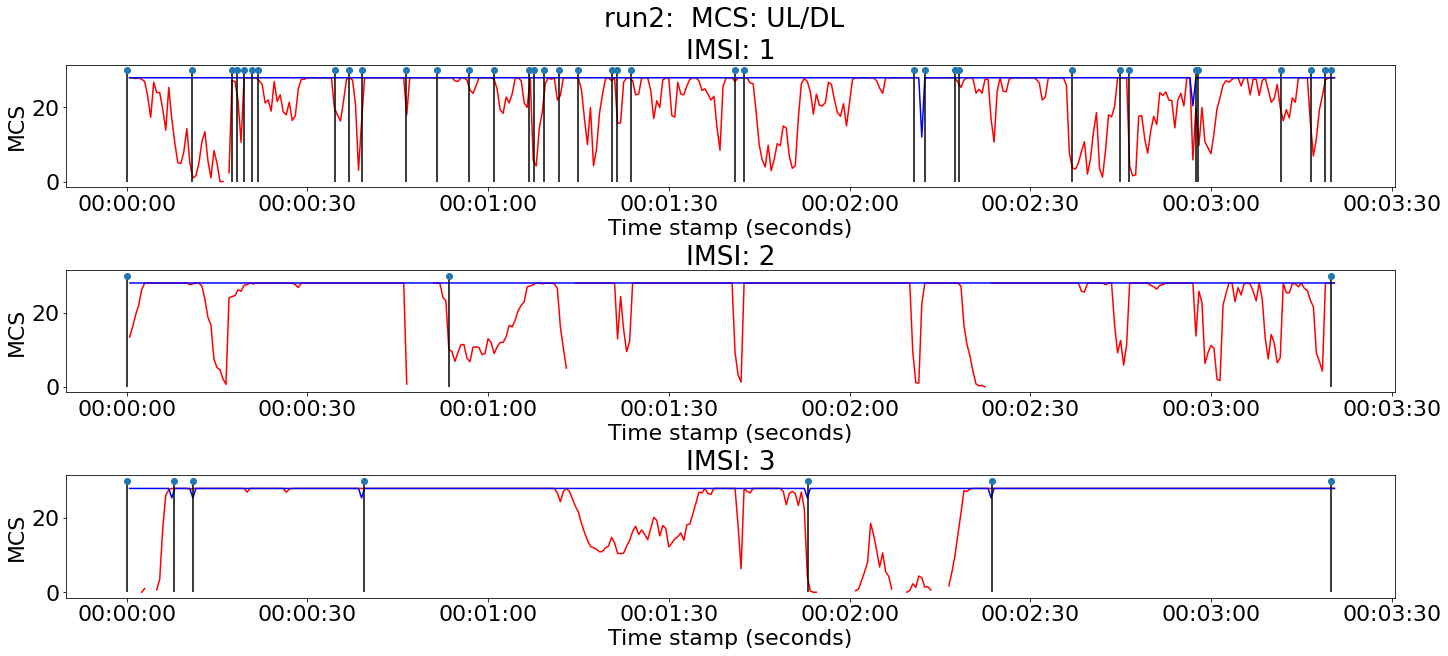

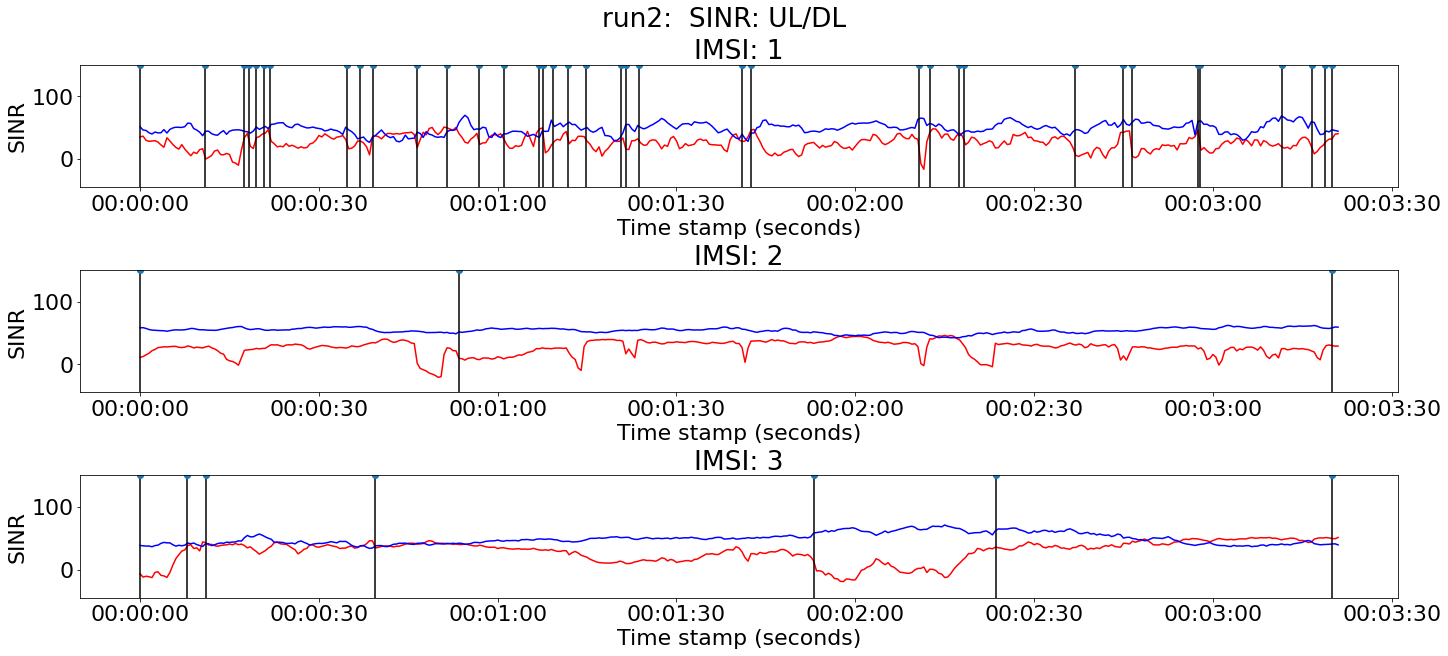

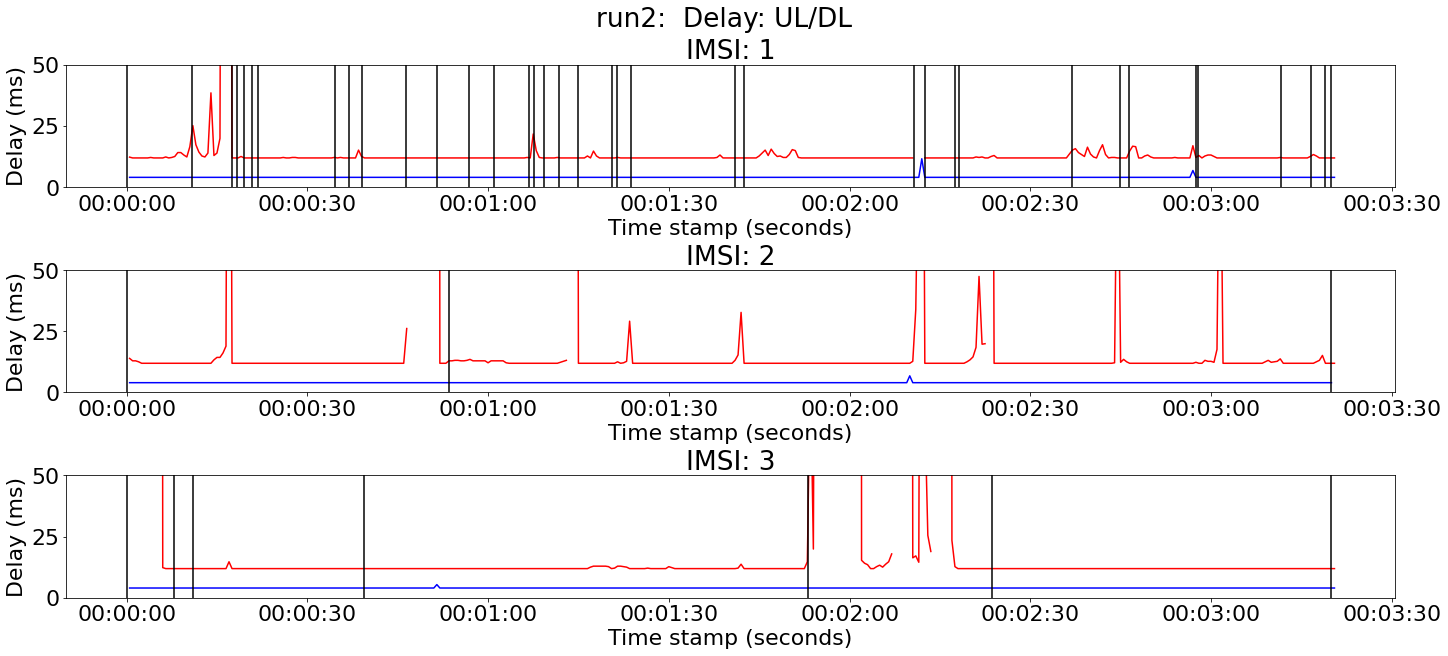

In [6]:
#=======================================
# Initilizing empty lists 
#=======================================

# To measure delay probe delivery rate 
# These are values aggregated over all UEs over the símulations time over all runs 
ul_delay_probe_delivery_rate = 0
dl_delay_probe_delivery_rate = 0
rtt_probe_delivery_rate = 0
ul_avg_thput = 0
dl_avg_thput = 0

# Baselines for empty networks
# Aggregate over UEs and runs for histogram plots
# These are arrays with samples aggregated over all UEs over the simulations time over all runs 
# These are not windowed 
ul_delays = np.empty(0)
dl_delays = np.empty(0)
rtt_delays = np.empty(0)
ul_thput = np.empty(0)
dl_thput = np.empty(0)
ul_mcs = np.empty(0)
dl_mcs = np.empty(0)
ul_sinr = np.empty(0)
dl_sinr = np.empty(0)

cell_ul_thput = np.empty(0)
cell_dl_thput = np.empty(0)



# Baselines for empty networks
# distance to BS versus metrics, aggregated over windows 
# These are arrays with samples aggregated over all UEs over the simulations time over all runs 
# These are windowed 
w_ul_delays = np.empty(0)
w_dl_delays = np.empty(0)
w_rtt_delays = np.empty(0)
w_ul_sinr = np.empty(0)
w_dl_sinr = np.empty(0)
w_rsrp = np.empty(0)
w_dist_to_cell = np.empty(0)
w_ul_mcs = np.empty(0)
w_dl_mcs = np.empty(0)

# mi here is multi-indexed, with time and IMSi as the 2 levels of indices 
mi_ul_delays = pd.DataFrame()
mi_dl_delays = np.empty(0)
mi_rtt_delays = np.empty(0)
mi_ul_sinr = np.empty(0)
mi_dl_sinr = np.empty(0)
mi_rsrp = np.empty(0)
mi_dist_to_cell = np.empty(0)



# app specific observations for plotting
# aggregated over all UEs running this app to plot histograms 
page_load_time = np.empty(0) # page load time over all webpages viewed 
webpage_size = np.empty(0) # size of the webpage 
segment_bitrate = np.empty(0) # bitrate of segment requested over all videos watched
vr_burst_time = np.empty(0) # time to receive a full burst in VR 

# handover related initializers
hos_per_cell_per_time = 0
time_bw_hos = np.empty(0) # seconds 

# constant multipliers
M = (10**6)
K = (10**3)

#=======================================
# Iterate over runs and files 
#=======================================


#=================================================================
#for run in os.listdir(data_dir):
#for run in tqdm(glob.glob(data_dir+'run3')):
for run in tqdm(glob.glob(data_dir+'run*')):
#=================================================================

    print('============================================================')
    print (run)
    print('============================================================')
    only_run = run.split('/')[-1]
    # check if run ran to completion
    with open(run+'/simulation_info.txt', "r") as sim_info_file:
        last_line = sim_info_file.readlines()[-1]
        if 'Elapsed wall clock' not in last_line:
            print('This run did not finish to completion, skipping it')
            continue
            
    # To store and compare the number of bytes sent and received in different RAN layers 
    bytes_matrix = np.zeros((4, 4), dtype=int)
    # time series plots for a chosen run 
    #if ts_plot_run_nums in run:
    if True:    
        # Aggregate plots from different files into one figure since we iterate over files
        # subplots for the chosen IMSI values for the one chosen run 
        # ul mcs, dl mcs figure
        if 'UlMacStats.txt'in files and 'DlMacStats.txt' in files:
            fig_mcs, axs_mcs = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)
            fig_mcs.suptitle(only_run+':  MCS: UL/DL')
        if 'DlRsrpSinrStats.txt' in files and 'UlSinrStats.txt' in files: 
            # ul sinr and dl sinr
            fig_sinr, axs_sinr = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)
            fig_sinr.suptitle(only_run+':  SINR: UL/DL')
        if 'delay_trace.txt' in files:
            # ul delay, dl delay, rtt figure 
            fig_delay, axs_delay = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)
            fig_delay.suptitle(only_run+':  Delay: UL/DL')
        if 'httpClientRtt_trace.txt' in files:
            # http web page objects 
            fig_http, axs_http = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)
            fig_http.suptitle(only_run+':  Time to fetch http web browser object (ms)')
        if 'dashClient_trace.txt' in files:
            # video segment bitrates 
            fig_bitrate, axs_bitrate = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True)
            fig_bitrate.suptitle(only_run+':  Video segment bitrate')
        
        
    
#=================================================================
    for file in files:
#=================================================================
        print('--------------------------------------------')
        print(file)
        start_time = time.time()
        
        #=======================================
        # Preprocess logs 
        #=======================================
        
        ## Read file while fixing the tab issue
        if file in files_with_trailing_tab:
            #df = pd.read_csv(data_dir+run+'/'+file, sep='\t', usecols=range(0,18))
            df = pd.read_csv(run+'/'+file, sep='\t', usecols=range(0,18))
            print(run+'/'+file)
        else:
            #df = pd.read_csv(data_dir+run+'/'+file, sep='\t')
            df = pd.read_csv(run+'/'+file, sep='\t')
            print(run+'/'+file)
        
        print('time to read file: ', (time.time() - start_time))
        
        
        ## Do some file specific preprocessing
        ## Make uniform the timestamp units convert them all to micro seconds 
        if '% time' in df.columns:
            df.rename(columns = {'% time':'tstamp_us'}, inplace = True)
            if file_name_to_tstamp_unit[file] == 'ms':
                df['tstamp_us'] = df['tstamp_us']*K
            elif file_name_to_tstamp_unit[file] == 's':
                df['tstamp_us'] = df['tstamp_us']*M
        ## Make uniform the timestamp units        
        if '% start' in df.columns:
            ## TO DO: check if this is actually micro seconds. I think it is seconds   
            df.rename(columns = {'% start':'tstamp_us'}, inplace = True)
            df.rename(columns = {'end':'end_timeslot_us'}, inplace = True)
            df['tstamp_us'] = df['tstamp_us']*M
            df['end_timeslot_us'] = df['end_timeslot_us']*M
        ## Some internally generated logs use the naming 'CellId' replace that with 'cellId'
        if ('CellId' in df.columns):
            df.rename(columns = {'CellId':'cellId'}, inplace = True)
        if ('currentCellId' in df.columns):
            df.rename(columns = {'currentCellId':'cellId'}, inplace = True)    
        
        # Warning: cellId and IMSI here are IP addresses, but it should not matter since 
        # there will only be 1 UE doing these ul and dl throughput scans   
        if 'dlThroughput_trace.txt':
            df.rename(columns = {'toAddr':'IMSI', 'fromAddr': 'cellId'}, inplace = True)
        if 'ulThroughput_trace.txt':
            df.rename(columns = {'toAddr':'cellId', 'fromAddr': 'IMSI'}, inplace = True)
            
        ## Just for plotting change the timestamp_us to seconds and delay values to milli seconds 
        ## since I am mostly plotting directly from pandas and don't know how to add a multiplicative factor to a column    
        if 'tstamp_us' in df.columns:
            df['tstamp_us'] = df['tstamp_us']/M
            # Set datetime index for all files so that we can do series operations 
            datatime_timestamps = pd.to_datetime(df['tstamp_us'], unit='s', origin='unix')
            df = df.set_index(datatime_timestamps, inplace=False)
            
            # add a sample at the beginning and ending of every timeseries at sim_start_time and sim_end_time. 
            # This way the timeseries after resampling are all of the same length 
            alignment_sample = np.empty(df.shape[1])
            alignment_sample[:] = np.nan
            start_sample = pd.DataFrame([alignment_sample], columns=df.columns, index=[sim_start_time])
            end_sample = pd.DataFrame([alignment_sample], columns=df.columns, index=[sim_end_time])
            if 'dir' in df.columns:
                for imsi in range(1,total_num_ues+1):
                    for di in ['UL', 'DL']:
                        start_sample['IMSI'] = imsi
                        start_sample['dir'] = di
                        end_sample['IMSI'] = imsi
                        end_sample['dir'] = di
                        df = pd.concat([start_sample, df, end_sample])
            elif 'cellId' in df.columns:
                for imsi in range(1,total_num_ues+1):
                    start_sample['IMSI'] = imsi
                    start_sample['cellId'] = 0
                    end_sample['IMSI'] = imsi
                    end_sample['cellId'] = 0
                    df = pd.concat([start_sample, df, end_sample])
            else:
                for imsi in range(1,total_num_ues+1):
                    start_sample['IMSI'] = imsi
                    end_sample['IMSI'] = imsi
                    df = pd.concat([start_sample, df, end_sample])
        
        if file == 'dlThroughput_trace.txt':
            df['IMSI'] = 1
        if file == 'ulThroughput_trace.txt':
            df['IMSI'] = 1
        
        # converting all delay values to ms instead of us
        if 'delay' in df.columns:
            df['delay'] = df['delay']/K
        
        #=======================================
        # Print log file info  
        #=======================================
        if print_logfile_info:
            ## Display info about the UEs who have made entries in this file to make sure that all the UEs who should be here are here. 
            print('ueIds: min:', min(df['IMSI'].value_counts().index), 'max:', max(df['IMSI'].value_counts().index),
                 'count:', len(df['IMSI'].value_counts().index))
            if len(df['IMSI'].value_counts().index) < total_num_ues:
                print('WARNING: Fewer UEs in this file than the total number in the simulation')
                print(df['IMSI'].value_counts())

            ## Display info about the Cells who have made entries in this file
            #print('cellIds: min:', min(df['cellId'].value_counts().index), 'max:', max(df['cellId'].value_counts().index),
            #     'count:', len(df['cellId'].value_counts().index))

            ## Total runtime of log
            print('log time (start, end): (', np.nanmin(df['tstamp_us']), ', ' ,np.nanmax(df['tstamp_us']), ')')
            print('log runtime:', (np.nanmax(df['tstamp_us']) - np.nanmin(df['tstamp_us'])), ' seconds')
        
        
        #=======================================
        # Byte matrix: Aggregate bytes over runs  
        #=======================================
        
        ## Gather the number of bytes sent from/to all UEs in each layer and direction to compare
        if file == 'DlTxPhyStats.txt':
            bytes_matrix[0,0] = df['size'].sum()/M
        elif file == 'DlRxPhyStats.txt':
            bytes_matrix[2,0] = df['size'].sum()/M
        elif file == 'UlTxPhyStats.txt':
            bytes_matrix[1,0] = df['size'].sum()/M
        elif file == 'UlRxPhyStats.txt':
            bytes_matrix[3,0] = df['size'].sum()/M
        elif file == 'DlMacStats.txt':
            bytes_matrix[0,1] = (df['sizeTb1'].sum() + df['sizeTb2'].sum())/M
        elif file == 'UlMacStats.txt':
            bytes_matrix[1,1] = df['size'].sum()/M
        elif file == 'DlRlcStats.txt':
            bytes_matrix[0,2] = df['TxBytes'].sum()/M
            bytes_matrix[2,2] = df['RxBytes'].sum()/M
        elif file == 'UlRlcStats.txt':
            bytes_matrix[1,2] = df['TxBytes'].sum()/M
            bytes_matrix[3,2] = df['RxBytes'].sum()/M
        elif file == 'DlPdcpStats.txt':
            bytes_matrix[0,3] = df['TxBytes'].sum()/M
            bytes_matrix[2,3] = df['RxBytes'].sum()/M
        elif file == 'UlPdcpStats.txt':
            bytes_matrix[1,3] = df['TxBytes'].sum()/M
            bytes_matrix[3,3] = df['RxBytes'].sum()/M

        
        #======================================================
        # File specific extraction and aggregation of metrics  
        #======================================================
        
        if file == 'UlMacStats.txt':
            cell_ul_thput = np.append(cell_ul_thput, df.groupby(by=['cellId'])['size'].resample(time_wind_str).sum()/M) # MB in each time window 
            ul_mcs = np.append(ul_mcs, df['mcs'])
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_ul_mcs = np.append(w_ul_mcs, df_parsed['mcs'])
        
        if file == 'DlMacStats.txt':
            cell_dl_thput = np.append(cell_dl_thput, df.groupby(by=['cellId'])['sizeTb1'].resample(time_wind_str).sum()/M) # MB
            dl_mcs = np.append(dl_mcs, df['mcsTb1'])
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_dl_mcs = np.append(w_dl_mcs, df_parsed['mcsTb1'])
        
        if file == 'DlRsrpSinrStats.txt':
            #grouping results in a mutli-indexed dataframe 
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            dl_sinr = np.append(dl_sinr, df['sinr'])
            w_rsrp = np.append(w_rsrp, df_parsed['rsrp'])
            w_dl_sinr = np.append(w_dl_sinr, df_parsed['sinr'])
          
        if file == 'UlSinrStats.txt':
            # note that the UL sinr is linear while the dl sinr is in dB (I think ... )
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_ul_sinr = np.append(w_ul_sinr, df_parsed['sinrLinear'])
            ul_sinr = np.append(ul_sinr, df_parsed['sinrLinear'])
            
        if file == 'delay_trace.txt':
            # separate UL and DL 
            ul_probes = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI']).size()
            dl_probes = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI']).size()
            #if ts_plot_run_nums in run:
            if True:    
                # group by UE
                print('UL # delay probe delivery rate per UE: ', ul_probes/(sim_time*10))
                print('DL # delay probes delivery rate per UE: ', dl_probes/(sim_time*10))
            #print('Sum of Delay probes for all UEs: UL: ', ul_probes.sum(), ' DL: ', dl_probes.sum())
            ul_delay_probe_delivery_rate = ul_delay_probe_delivery_rate + ul_probes.sum()
            dl_delay_probe_delivery_rate = dl_delay_probe_delivery_rate + dl_probes.sum()
            # for histogram
            ul_delays = np.append(ul_delays, df.groupby(by=['dir']).get_group('UL')['delay'])
            dl_delays = np.append(dl_delays, df.groupby(by=['dir']).get_group('DL')['delay'])
            
            # need to organize by UE IMSI
            df_ul_parsed = df.groupby(by=['dir']).get_group('UL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')  
            df_dl_parsed = df.groupby(by=['dir']).get_group('DL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_ul_delays = np.append(w_ul_delays, df_ul_parsed['delay'])
            w_dl_delays = np.append(w_dl_delays, df_dl_parsed['delay'])
            #for name, group in df.groupby(by=['dir']).get_group('UL').sort_values(by=['IMSI']).groupby(by=['IMSI']):
            #    print(name, group.resample(time_wind_str).mean().shape[0])
            #    print(name, group.resample(time_wind_str).mean().index[0])
            #    print(name, group.resample(time_wind_str).mean().index[-1])
            
        if file == 'rtt_trace.txt':
            rtt_probes = df.groupby(by=['IMSI']).size()
            # group by UE
            #print('# RTT probes per UE: ', rtt_probes)
            #print('Sum of RTT probes for all UEs: ', rtt_probes.sum())
            rtt_probe_delivery_rate = rtt_probe_delivery_rate + rtt_probes.sum()
            # for histogram
            rtt_delays = np.append(rtt_delays, df['delay'])
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_rtt_delays = np.append(w_rtt_delays, df_parsed['delay'])
            
        if file == 'ulThroughput_trace.txt':
            ul_avg_thput = ul_avg_thput + (df['pktSize'].sum()/M) # MB
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
            # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs
            df_parsed = df.resample(time_wind_str).sum()*8/(time_wind_val*K)
            df_parsed = df_parsed[sim_start_time : sim_end_time]# Mbps
            ul_thput = np.append(ul_thput, df_parsed['pktSize'])# Mbps
            
        if file == 'dlThroughput_trace.txt':
            dl_avg_thput = dl_avg_thput + (df['pktSize'].sum()/M) # MB
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
            # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs
            df_parsed = df.resample(time_wind_str).sum()*8/(time_wind_val*K)
            df_parsed = df_parsed[sim_start_time : sim_end_time]# Mbps
            dl_thput = np.append(dl_thput, df_parsed['pktSize'])# Mbps   
        
        if file == 'handover_trace.txt':
            hos_per_cell_per_time = hos_per_cell_per_time + df.shape[0]
            time_bw_hos = np.append(time_bw_hos, df.groupby(by=['IMSI'])['tstamp_us'].diff().dropna())   
            
        
        if file == 'mobility_trace.txt':
            # add a distance column which is the distance from the UE to the cell it is connected to
            gnb_pos = [dict_gnb_pos[cellId] for cellId in df['cellId'].to_numpy()]
            ue_pos = df[['pos_x', 'pos_y']].to_numpy()
            distance = [math.dist([gnb_loc['gnbpos_x'],gnb_loc['gnbpos_y']], ue_loc) for gnb_loc,ue_loc in zip(gnb_pos,ue_pos)]          
            # gnb_pos is a list of dictionaries as well with keys {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5}
            # so it is a list of dictionaries 
            # Does it have 0 IMSI values ? if so then I need to remove it  
            # add distance as a column 
            df['dist_to_cell'] = distance
            df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
            w_dist_to_cell = np.append(w_dist_to_cell, 
                                       df_parsed['dist_to_cell'])
            #for name, group in df.sort_values(by=['IMSI']).groupby(by=['IMSI']):
            #    print(name, group.resample(time_wind_str).mean().shape[0])
            #    print(name, group.resample(time_wind_str).mean().index[0])
            #    print(name, group.resample(time_wind_str).mean().index[-1])
            
        if file == 'httpClientRtt_trace.txt':
            # get page load time 
            # grouped by IMSI, by web page id 
            # doubt this will work but I need to see if there is a way to do this without a nested for loop
            #page_load_time = np.append( page_load_time, df.groupby(by=['IMSI']).groupby(by=['webpageId'])['delay'].sum() )
            #webpage_size = np.append( webpage_size, df.groupby(by=['IMSI']).groupby(by=['webpageId'])['objectSize'].sum() )
            for name1, group1 in df.groupby(by=['IMSI']):
                for name2, group2 in group1.groupby(by=['webpageId']):
                    page_load_time = np.append(page_load_time, group2['delay'].sum())
                    webpage_size = np.append(webpage_size, group2['objectSize'].sum())
                
        if file == 'vrFragment_trace.txt':
            # time to send a VR burst of pictures
            for name1, group1 in df.groupby(by=['IMSI']):
                for name2, group2 in group1.groupby(by=['burstSeqNum']):
                    this_run_vr_burst_time = group2['delay'].sum()
                    vr_idx = group2['delay'].index
                    vr_burst_time = np.append(vr_burst_time, this_run_vr_burst_time)
        
        if file == 'dashClient_trace.txt':
            segment_bitrate = np.append(segment_bitrate, df['newBitRate_bps'])
        
        #if file == 'flow_trace.txt':
        #    # separate UL and DL 
        #    ul_brate = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
        #    ul_brate = ul_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
        #    dl_brate = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
        #    dl_brate = dl_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
        #    # group by UE
        #    print('UL brate Mbps per UE: ', ul_brate)
        #    print('DL brate Mbps per UE: ', dl_brate)
        #    #print('UL Giga Bytes sent by each UE over the duration of the simulation: ', ul_bytes_sent)
        #    #print('DL Giga Bytes sent by each UE over the duration of the simulation: ', dl_bytes_sent)
        
        #=======================================
        # Plot timeseries   
        #=======================================
        
        #if (timeseries_plots and (ts_plot_run_nums in run) ):    
        if (timeseries_plots and (True) ):        
            # To see samples of various metrics in cmparison with each other as they change                
            ## RAN plots (UL mcs overlayed on DL mcs) for samples UEs in a sample run 
            if file == 'DlMacStats.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                    #print('imsis in df', df['IMSI'].unique())
                    val = df.groupby(by=['IMSI']).get_group(ue)['mcsTb1'].resample(time_wind_str).mean()
                    axs_mcs[ix].plot(val.index, val, color='b')
                    axs_mcs[ix].set_xlabel('Time stamp (seconds)')
                    axs_mcs[ix].set_ylabel('MCS')
                    axs_mcs[ix].set_title('IMSI: '+str(ue))
            elif file == 'UlMacStats.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                    #print('imsis in df', df['IMSI'].unique())
                    val = df.groupby(by=['IMSI']).get_group(ue)['mcs'].resample(time_wind_str).mean()
                    axs_mcs[ix].plot(val.index, val, color='r')
            elif file == 'DlRsrpSinrStats.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                    #print('imsis in df', df['IMSI'].unique())
                    val = df.groupby(by=['IMSI']).get_group(ue)['sinr'].resample(time_wind_str).mean()
                    axs_sinr[ix].plot(val.index, 10*np.log10(val), color='b')
                    axs_sinr[ix].set_xlabel('Time stamp (seconds)')
                    axs_sinr[ix].set_ylabel('SINR')
                    #axs_sinr[ix].set_ylim(-45,100) (-45,65)
                    axs_sinr[ix].set_title('IMSI: '+str(ue))
            elif file == 'UlSinrStats.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                    #print('imsis in df', df['IMSI'].unique())
                    val = df.groupby(by=['IMSI']).get_group(ue)['sinrLinear'].resample(time_wind_str).mean()
                    axs_sinr[ix].plot(val.index, 10*np.log10(val), color='r')
                    axs_sinr[ix].set_ylim(-45,150)
            ## Delay plots (UL delay, DL delay and RTT overlayed) 
            elif file == 'delay_trace.txt':
                df_ul = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI'])
                df_dl = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI'])
                for ix, ue in enumerate(ts_plot_IMSIs):
                    val = df_ul.get_group(ue)['delay'].resample(time_wind_str).mean()
                    axs_delay[ix].plot(val.index, val, color='r')
                    axs_delay[ix].set_xlabel('Time stamp (seconds)')
                    axs_delay[ix].set_ylabel('Delay (ms)')
                    axs_delay[ix].set_ylim(0,50)
                    axs_delay[ix].set_title('IMSI: '+str(ue))
                for ix, ue in enumerate(ts_plot_IMSIs):
                    val = df_dl.get_group(ue)['delay'].resample(time_wind_str).mean()
                    axs_delay[ix].plot(val.index, val, color='b')
                    axs_delay[ix].set_ylim(0,50)
            #elif file == 'rtt_trace.txt':
            #    print(df['IMSI'].value_counts())
            #    for ix, ue in enumerate(ts_plot_IMSIs):
            #        val = df.groupby(by=['IMSI']).get_group(ue)['delay']
            #        print(ix)
            #        axs_delay[ix].plot(val.index, val, color='magenta')
            #        axs_delay[ix].set_ylim(0,500)
            ## Browsing: Time between object request and object download (confirm this from the ns3 model)
            elif file == 'handover_trace.txt':      
                    #overlay handover shifts on delay timeseries
                for ix, ue in enumerate(ts_plot_IMSIs):
                    val = df.groupby(by=['IMSI']).get_group(ue)['cellId']
                    axs_delay[ix].stem(val.index, np.ones(val.shape[0])*1000, linefmt='k', basefmt=" ")
                    axs_mcs[ix].stem(val.index, np.ones(val.shape[0])*30, linefmt='k', basefmt=" ") 
                    axs_sinr[ix].stem(val.index, np.ones(val.shape[0])*150, linefmt='k', bottom=-45, basefmt=" ") 
            elif file == 'httpClientRtt_trace.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    val = df.groupby(by=['IMSI']).get_group(ue)['delay']
                    axs_http[ix].plot(val.index, val, color='r')
                    axs_http[ix].set_xlabel('Time stamp (seconds)')
                    axs_http[ix].set_ylabel('http object RTT (ms)')
                    axs_http[ix].set_title('IMSI: '+str(ue))
            elif file == 'dashClient_trace.txt':
                for ix, ue in enumerate(ts_plot_IMSIs):
                    val = df.groupby(by=['IMSI']).get_group(ue)['newBitRate_bps']
                    axs_bitrate[ix].plot(val.index, val, color='r')
                    axs_bitrate[ix].set_xlabel('Time stamp (seconds)')
                    axs_bitrate[ix].set_ylabel('Video segment bitrate')
                    axs_bitrate[ix].set_title('IMSI: '+str(ue))
            elif file == 'ulThroughput_trace.txt':
                val = df_parsed['pktSize'] # assuming it was parsed before 
                plt.figure(figsize=(20,3))
                fname=plot_dir+'ts_ul_throughput.png'
                plt.plot(val.index, val, color='r')
                plt.xlabel('Time stamp (seconds)')
                plt.ylabel('UL Throughput (Mbps)')
                plt.savefig(fname)
                plt.show()
                #wandb.log({"UL Throughput (Mbps)": wandb.Image(fname)})
        
            elif file == 'dlThroughput_trace.txt':
                val = df_parsed['pktSize'] # assuming it was parsed before 
                plt.figure(figsize=(20,3))
                plt.plot(val.index, val, color='b')
                plt.xlabel('Time stamp (seconds)')
                plt.ylabel('DL Throughput (Mbps)')
                plt.savefig(plot_dir+'ts_dl_throughput.png')
                plt.show()
                #wandb.log({"DL Throughput (Mbps)": plt})
            elif file == 'vrFragment_trace.txt': 
                plt.figure(figsize=(20,3))
                plt.plot(vr_idx, this_run_vr_burst_time, color='b')
                plt.xlabel('Time stamp (seconds)')
                plt.ylabel('VR time to send packet burst (ms)')
                plt.savefig(plot_dir+'ts_vr_time_to_send_packet_burst.png')
                plt.show()
                #wandb.log({"VR time to send packet burst (ms)": plt})
        # end of timeseries_plots
    # end of for over files 
    #if ts_plot_run_nums in run:
    if True:    
        # save plots and send to wandb
        if 'DlRsrpSinrStats.txt' and 'UlSinrStats.txt': 
            fname=plot_dir+'timeseries_sinr.png'
            fig_sinr.savefig(fname)
            fig_sinr.show()
            print('===========================================================================================')
            #wandb.log({"timeseries of UL/DL SINR": wandb.Image(fname)})
            
        if 'UlMacStats.txt' and 'DlMacStats.txt':
            fname=plot_dir+'timeseries_mcs.png'
            fig_mcs.savefig(fname)
            fig_mcs.show()
            #wandb.log({"timeseries of UL/DL MCS": wandb.Image(fname)})
        if 'delay_trace.txt':
            fname=plot_dir+'timeseries_delay.png'
            fig_delay.savefig(fname)
            fig_delay.show()
            print('===========================================================================================')
            #wandb.log({"timeseries of UL/DL delay (ms)": wandb.Image(fname)})

        if 'httpClientRtt_trace.txt' in files:
            fname=plot_dir+'timeseries_http_delay.png'
            fig_http.savefig(fname)
            fig_http.show()
            print('===========================================================================================')
            #wandb.log({"timeseries of Time to receive http object (ms)": wandb.Image(fname)})
        if 'dashClient_trace.txt' in files:
            fname=plot_dir+'timeseries_dash_bitrate.png'
            fig_bitrate.savefig(fname)
            fig_bitrate.show()
            print('===========================================================================================')
            #wandb.log({"timeseries of Video segment bitrate": wandb.Image(fname)})     
        
    #=======================================
    # Print per run byte matrix in MB   
    #=======================================
    if print_byte_matrix:
        print ('Byte Matrix in MB')
        print('  X  phy mac rlc pdcp\n' + \
              'dlTx  x   x   x   x\n' + \
              'ulTx  x   x   x   x\n' + \
              'dlRx  x   x   x   x\n' + \
              'ulRx  x   x   x   x')
        print(bytes_matrix)

# end of for over runs

print('============================================================')
# some post processing 
if 'UlMacStats.txt' in files:
    cell_ul_thput = cell_ul_thput*8/(time_wind_val/K)#Mbps
if 'DlMacStats.txt' in files:
    cell_dl_thput = cell_dl_thput*8/(time_wind_val/K)#Mbps

In [7]:
#=======================================
# Print summary statistics   
#=======================================  
if 'delay_trace.txt' in files: 
    print('--------------------------------------------')
    print("UL delay probe delivery rate: ", ul_delay_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs))
    print("DL delay probe delivery rate: ", dl_delay_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs))
    print('--------------------------------------------')
    print("Summary stats: ul_delays")
    print(pd.Series(ul_delays).describe())
    print('0.95 quantile: ', np.nanquantile(ul_delays,0.95))
    print('0.97 quantile: ', np.nanquantile(ul_delays,0.97))
    print('0.99 quantile: ', np.nanquantile(ul_delays,0.99))
    print('--------------------------------------------')
    print("Summary stats: dl_delays")
    print(pd.Series(dl_delays).describe())
    print('0.95 quantile: ', np.nanquantile(dl_delays,0.95))
    print('0.97 quantile: ', np.nanquantile(dl_delays,0.97))
    print('0.99 quantile: ', np.nanquantile(dl_delays,0.99))
if 'rtt_trace.txt' in files:
    print('--------------------------------------------')
    print("RTT probe delivery rate: ", rtt_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs))
    print('--------------------------------------------')
    print("Summary stats: rtt_delays")
    print(pd.Series(rtt_delays).describe())
    print('0.95 quantile: ', np.nanquantile(rtt_delays,0.95))
    print('0.97 quantile: ', np.nanquantile(rtt_delays,0.97))
    print('0.99 quantile: ', np.nanquantile(rtt_delays,0.99))
    
if 'ulThroughput_trace.txt' in files:
    print('--------------------------------------------')
    print("UL survey average thoughput (Mbps): ", ul_avg_thput*8/(sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: ul_thput (Mbps)")
    print(pd.Series(ul_thput).describe())
    print('0.95 quantile: ', np.nanquantile(ul_thput,0.95))
    print('0.97 quantile: ', np.nanquantile(ul_thput,0.97))
    print('0.99 quantile: ', np.nanquantile(ul_thput,0.99))
if 'dlThroughput_trace.txt' in files:
    print('--------------------------------------------')
    print("DL survey average thoughput (Mbps): ", dl_avg_thput*8/(sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: dl_thput (Mbps)")
    print(pd.Series(dl_thput).describe())
    print('0.95 quantile: ', np.nanquantile(dl_thput,0.95))
    print('0.97 quantile: ', np.nanquantile(dl_thput,0.97))
    print('0.99 quantile: ', np.nanquantile(dl_thput,0.99))
if 'handover_trace.txt' in files:
    print('--------------------------------------------')
    print('Number of handover per cell every 100 s: ', hos_per_cell_per_time*100/(total_num_cells*sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: time bw handovers (seconds)")
    print(pd.Series(time_bw_hos).describe())
    print('0.95 quantile: ', np.nanquantile(time_bw_hos,0.95))   

--------------------------------------------
UL delay probe delivery rate:  0.9783
DL delay probe delivery rate:  1.001
--------------------------------------------
Summary stats: ul_delays
count    58638.000000
mean       107.577794
std        649.646971
min          4.932000
25%         11.931000
50%         11.931000
75%         11.931000
max      11793.932000
dtype: float64
0.95 quantile:  130.931
0.97 quantile:  742.7109999999989
0.99 quantile:  2810.6009999999765
--------------------------------------------
Summary stats: dl_delays
count    60000.000000
mean         4.030800
std          0.627823
min          3.999000
25%          3.999000
50%          3.999000
75%          3.999000
max         80.999000
dtype: float64
0.95 quantile:  3.999
0.97 quantile:  3.999
0.99 quantile:  3.999
--------------------------------------------
RTT probe delivery rate:  0.9783
--------------------------------------------
Summary stats: rtt_delays
count    58638.000000
mean       111.050417
std   

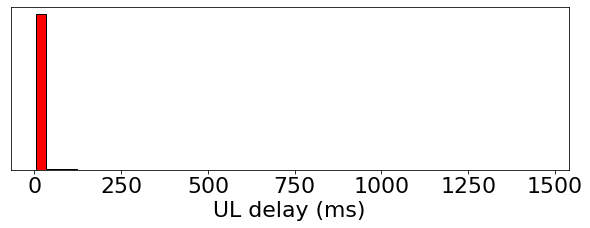

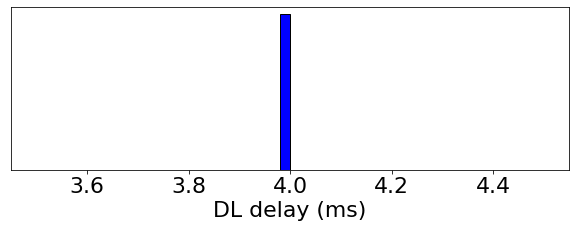

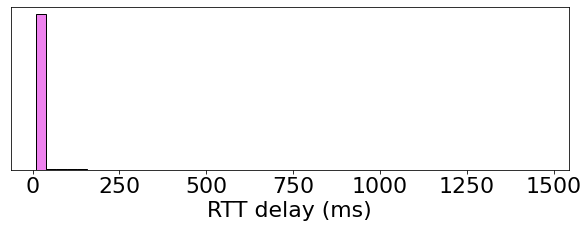

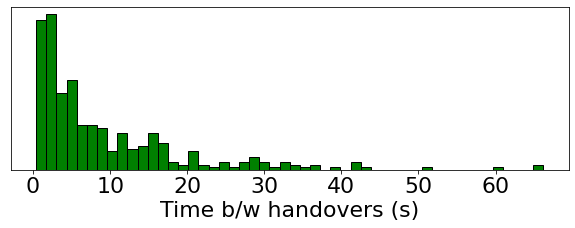

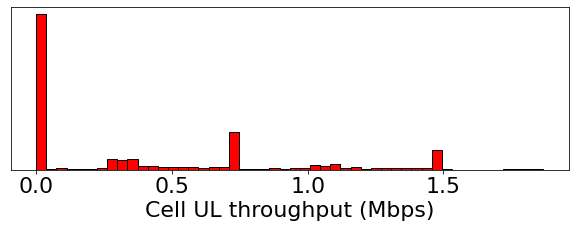

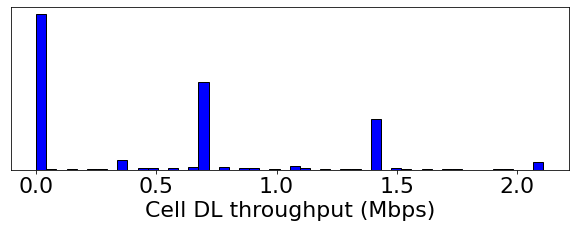

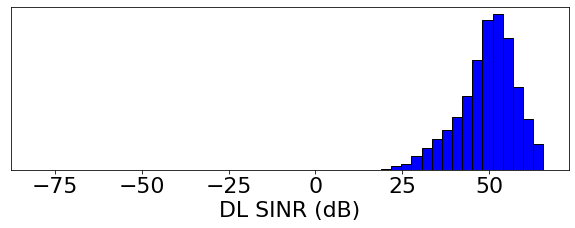

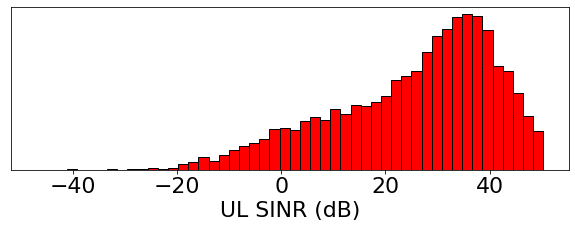

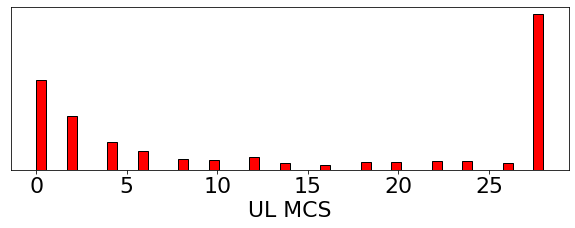

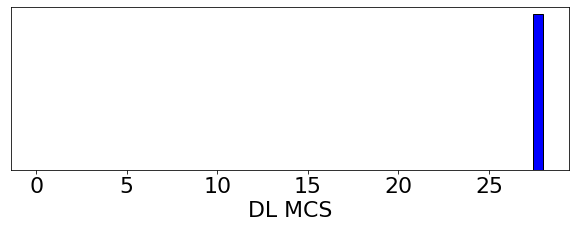

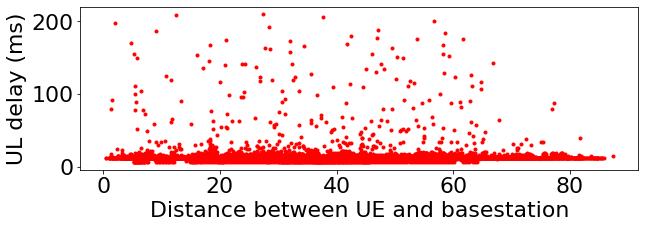

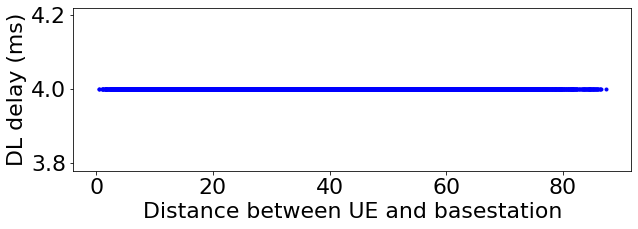

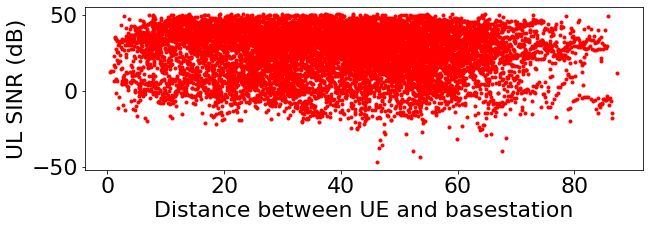

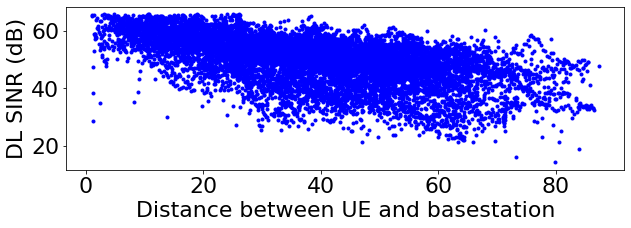

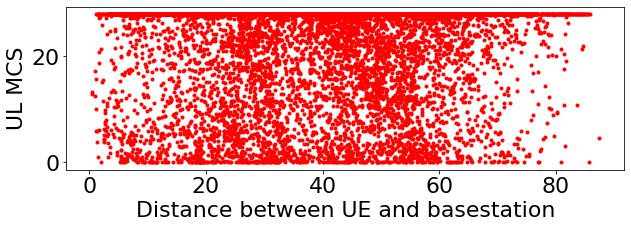

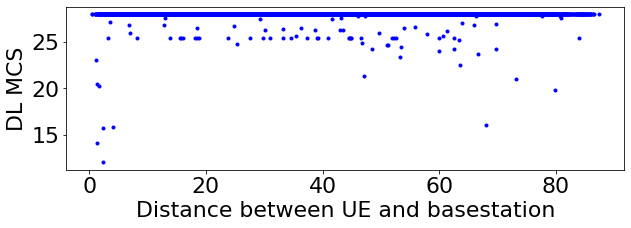

DONE


In [8]:
#=======================================
# Plot histograms   
#=======================================
# for metrics related to delay we are removing outliers using the 99th percentile value so that we can 
# get a better view of what is happenning in the data

if histogram_plots:
    if ('delay_trace.txt' in files):
        plot_histogram(ul_delays, 'red', 'UL delay (ms)', 'hist_ul_delays.png', plot_dir)
        plot_histogram(dl_delays, 'blue', 'DL delay (ms)', 'hist_dl_delays.png', plot_dir)
    if ('rtt_trace.txt' in files):
        plot_histogram(rtt_delays, 'violet', 'RTT delay (ms)', 'hist_rtt_delays.png', plot_dir)
    if ('ulThroughput_trace.txt' in files):
        plot_histogram(ul_thput, 'red', 'UL thput (Mbps)', 'hist_ul_thput.png', plot_dir)
    if ('dlThroughput_trace.txt' in files):
        plot_histogram(dl_thput, 'blue', 'DL thput (Mbps)', 'hist_dl_thput.png', plot_dir)
    if ('handover_trace.txt' in files):
        plot_histogram(time_bw_hos, 'green', 'Time b/w handovers (s)', 'hist_time_bw_hos.png', plot_dir)
    if ('httpClientRtt_trace.txt' in files):
        plot_histogram(page_load_time, 'green', 'Page load time for webpages (ms)', 'hist_page_load_time.png', plot_dir)
    if ('httpClientRtt_trace.txt' in files):
        plot_histogram(webpage_size, 'green', 'Webpage size (B)', 'hist_webpage_size.png', plot_dir)
    if ('dashClient_trace.txt' in files): 
        plot_histogram(segment_bitrate, 'green', 'Video segment bitrate', 'hist_segment_bitrate.png', plot_dir)
    if ('vrFragment_trace.txt' in files): 
        plot_histogram(vr_burst_time, 'green', 'VR time to send packet burst (ms)', 'hist_vr_burst_time.png', plot_dir)
    if ('UlMacStats.txt' in files):
        plot_histogram(cell_ul_thput, 'red', 'Cell UL throughput (Mbps)', 'hist_cell_ul_thput.png', plot_dir)
    if ('DlMacStats.txt' in files): 
        plot_histogram(cell_dl_thput, 'blue', 'Cell DL throughput (Mbps)', 'hist_cell_dl_thput.png', plot_dir)
    if ('DlRsrpSinrStats.txt' in files):
        plot_histogram(10*np.log10(dl_sinr), 'blue', 'DL SINR (dB)', 'hist_dl_sinr.png', plot_dir)
        #plot_histogram(10*np.log10(dl_rsrp), 'blue', 'DL RSRP (dB)', 'hist_dl_rsrp.png', plot_dir)
    if ('UlSinrStats.txt' in files):
        plot_histogram(10*np.log10(ul_sinr), 'red', 'UL SINR (dB)', 'hist_ul_sinr.png', plot_dir)
    if ('UlMacStats.txt' in files): 
        plot_histogram(ul_mcs, 'red', 'UL MCS', 'hist_ul_mcs.png', plot_dir)
    if ('DlMacStats.txt' in files): 
        plot_histogram(dl_mcs, 'blue', 'DL MCS', 'hist_dl_mcs.png', plot_dir)
        
        
#=======================================
# Plot metrics vs UE-BS distance   
#======================================= 
if distance_plots:
    #print('Each plot with sample size: ', w_dist_to_cell.size)
    if ('delay_trace.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_ul_delays, 'red', 'UL delay (ms)', 'dist_vs_ul_delay.png', plot_dir)
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_dl_delays, 'blue', 'DL delay (ms)', 'dist_vs_dl_delay.png', plot_dir)
    #if ('rtt_trace.txt' in files):       
        #plot_metric_vs_distance_to_cell(w_dist_to_cell, w_rtt_delays, 'violet', 'RTT delay (ms)', 'dist_vs_rtt_delay.png', plot_dir)
    if ('ulThroughput_trace.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, ul_thput, 'red', 'UL throughput (Mbps)', 'dist_vs_ul_thput.png', plot_dir)
    if ('dlThroughput_trace.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, dl_thput, 'blue', 'DL throughput (Mbps)', 'dist_vs_dl_thput.png', plot_dir)
    if ('UlSinrStats.txt' in files):       
        plot_metric_vs_distance_to_cell(w_dist_to_cell, 10*np.log10(w_ul_sinr), 'red', 'UL SINR (dB)', 'dist_vs_ul_sinr.png', plot_dir)
        # for a single user 
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = 10*np.log10(w_ul_sinr[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ])
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'red', 'UL SINR (dB)', 'dist_vs_ul_sinr.png', plot_dir)
    if ('DlRsrpSinrStats.txt' in files):  
        plot_metric_vs_distance_to_cell(w_dist_to_cell, 10*np.log10(w_dl_sinr), 'blue', 'DL SINR (dB)', 'dist_vs_dl_sinr.png', plot_dir)
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = 10*np.log10(w_dl_sinr[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ])
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'blue', 'DL SINR (dB)', 'dist_vs_dl_sinr.png', plot_dir)
    if ('UlMacStats.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_ul_mcs, 'red', 'UL MCS', 'dist_vs_ul_mcs.png', plot_dir)
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = w_ul_mcs[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'red', 'UL MCS', 'dist_vs_ul_mcs.png', plot_dir)
    if ('DlMacStats.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_dl_mcs, 'blue', 'DL MCS', 'dist_vs_dl_mcs.png', plot_dir)
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = w_dl_mcs[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'blue', 'DL MCS', 'dist_vs_dl_mcs.png', plot_dir)
        
            
print('DONE')
#wandb.finish    

In [67]:
import os
os.system('cp parse_visualize_data.ipynb '+'./saved_notebooks/'+data_dir.split('/')[-2]+'.ipynb')

0